# Dunnhumby Sales Analysis Project

โจทย์ : ดึงข้อมูล Transaction Data ด้วย SQL เพื่อวิเคราะห์ยอดขายสินค้าด้วย Python

## 1. Database Connection

เชื่อมต่อฐานข้อมูล Postgres ด้วยการใช้ psycopg2 เพื่อเข้าถึงชุดข้อมูล

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# เชื่อมต่อ Database (Postgresql)
hostname = 'localhost'
database = 'Dunnhumby'
username = 'postgres'
pwd = '2003'
port_id = 5432

try:
    conn = psycopg2.connect(
            host=hostname,
            dbname=database,
            user=username,
            password=pwd,
            port=port_id
    )
    print("Database connected")
except Exception as e:
    print(f"connection fail: {e}")

Database connected


## 2. ตรวจสอบยอดขายรายวัน

ตรวจสอบลักษณะของยอดขายรายวัน

In [2]:
# Query สำหรับดึงยอดขายจริงรายวัน
query_rev = """
SELECT 
    "DAY", 
    SUM("SALES_VALUE") AS daily_revenue
FROM transaction_data
GROUP BY "DAY"
ORDER BY "DAY" ASC;
"""

In [3]:
# ดึงผลลัพธ์มาเก็บใน DataFrame
total_rev = pd.read_sql(query_rev, conn)

# เช็คจำนวนวันทั้งหมดที่ดึงมาได้
print(f"Data: {len(total_rev)} days")

C:\Users\User\AppData\Local\Temp\ipykernel_27576\3191683489.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_rev = pd.read_sql(query_rev, conn)


Data: 711 days


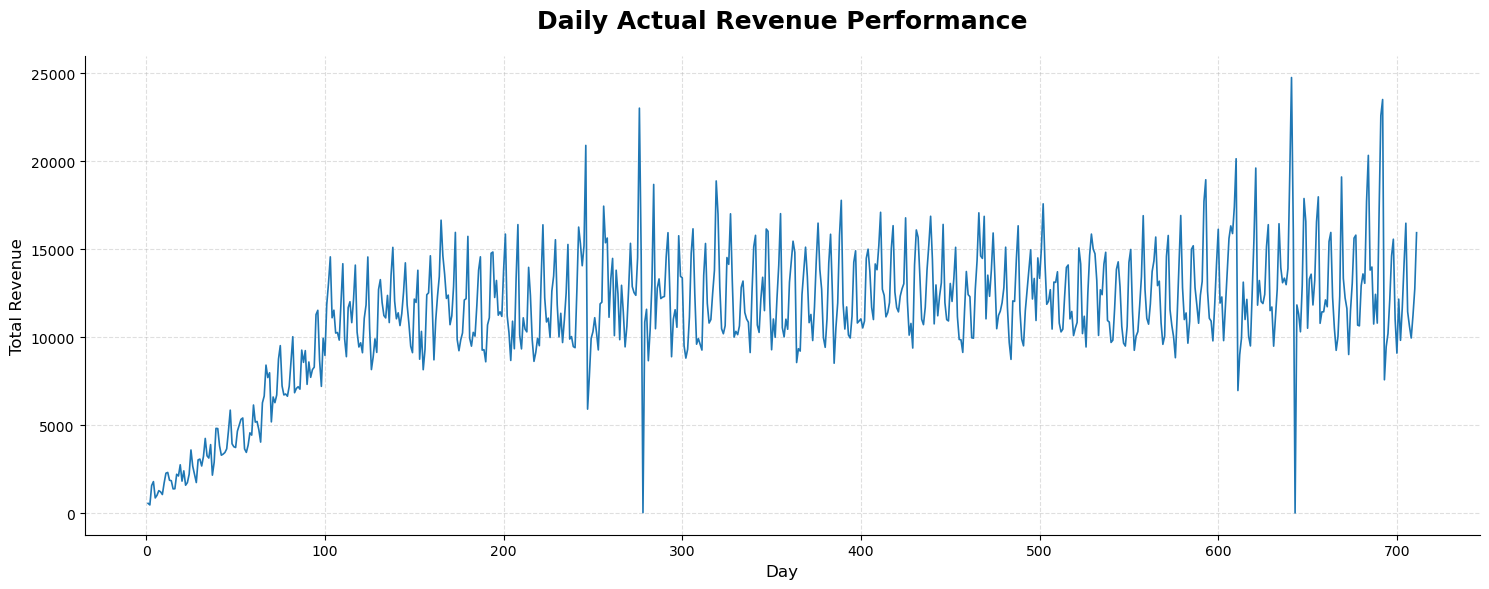

In [4]:
# ตั้งค่าสไตล์และขนาดกราฟ
fig, ax = plt.subplots(figsize=(15, 6))

# พล็อตเส้นยอดขายจริง (Actual Daily Sales)
ax.plot(total_rev['DAY'], total_rev['daily_revenue'], 
        color='#1f77b4', linewidth=1.2, label='Actual Daily Sales')

# ลักษณะกราฟ
ax.set_title('Daily Actual Revenue Performance', fontsize=18, pad=20, fontweight='bold')
ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Total Revenue', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

### การวิเคราะห์ยอดขายรายวัน (Daily Sales Analysis)**

*   **คำอธิบาย:**
    *   ในช่วง 100 วันแรกยอดขายมีลักษณะเพิ่มขึ้นเรื่อยๆ อาจมีพฤติกรรมบางอย่างที่ต้องตรวจสอบ
    *   ยอดขายรายวันมีความผันผวน อาจเกิดจากอิทธิพลของฤดูกาล (Seasonality)

## 3. ตรวจสอบหาสาเหตุของรายรับที่เพิ่มขึ้นอย่างรวดเร็วในช่วง 100 วันแรก

### ตรวจสอบแนวโน้มขาขึ้นของช่วง 100 วันแรก

จากกราฟรายได้ที่มีลักษณะไต่ระดับขึ้นอย่างรวดเร็วใน 100 วันแรกอาจจะมาจาก 2 สาเหตุคือ
- เป็นช่วงที่มีผู้คนใช้จ่ายมากขึ้น 
- ยอดใช้จ่ายเฉลี่ยไม่มีการเปลี่ยนแปลงแต่เป็นช่วงที่มีจำนวนธุรกรรมเพิ่มมากขึ้น

In [5]:
# Query สำหรับดึง Traffic และ Average Spend รายวัน
query_daily_metrics = """
SELECT 
    "DAY", 
    COUNT(DISTINCT "household_key") AS traffic_users,
    SUM("SALES_VALUE") / COUNT(DISTINCT "BASKET_ID") AS avg_spend
FROM transaction_data
GROUP BY "DAY"
ORDER BY "DAY" ASC;
"""

In [6]:
# ดึงข้อมูลจากฐานข้อมูล
df_daily_metrics = pd.read_sql(query_daily_metrics, conn)

# ตรวจสอบข้อมูล
df_daily_metrics

C:\Users\User\AppData\Local\Temp\ipykernel_27576\908179719.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_daily_metrics = pd.read_sql(query_daily_metrics, conn)


,DAY,traffic_users,avg_spend
0,1,15,34.331875
1,2,12,35.300769
2,3,33,35.462955
3,4,36,40.582727
4,5,23,34.277200
...,...,...,...
706,707,310,29.290248
707,708,315,25.911198
708,709,317,29.672137
709,710,339,31.423744


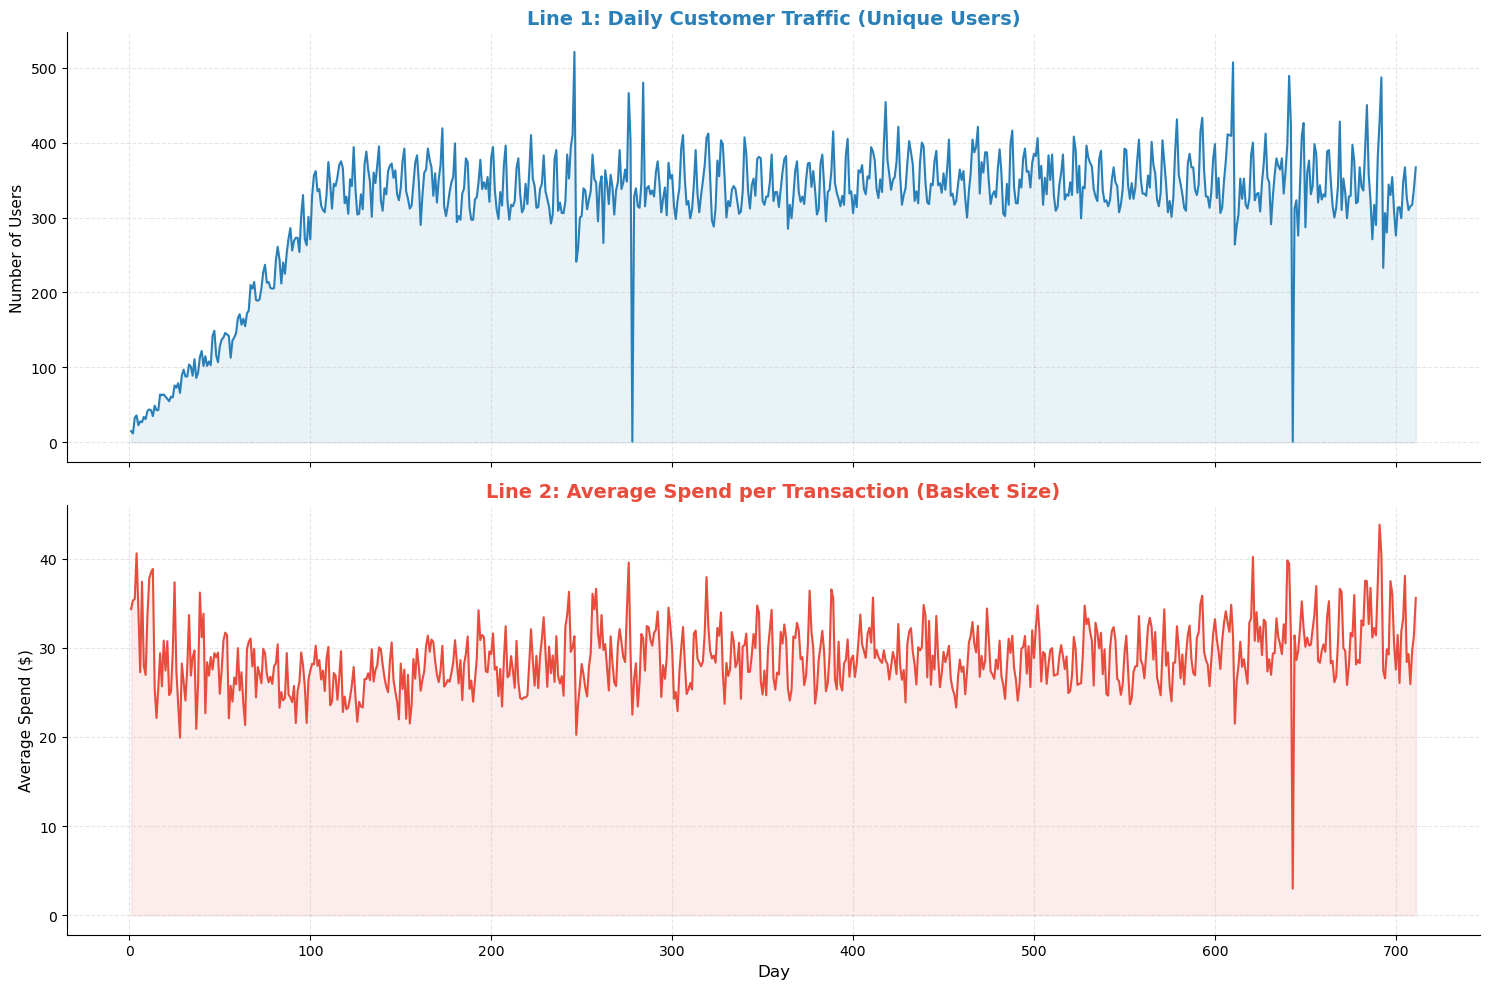

In [7]:
# ตั้งค่ากราฟ (2 รูปบน-ล่าง)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# กราฟบน: Daily Traffic (จำนวนผู้ใช้งาน) สีน้ำเงิน
ax1.plot(df_daily_metrics['DAY'], df_daily_metrics['traffic_users'], 
         color='#2980b9', linewidth=1.5, label='Daily Unique Users')
ax1.fill_between(df_daily_metrics['DAY'], df_daily_metrics['traffic_users'], 
                 color='#2980b9', alpha=0.1)
ax1.set_title('Line 1: Daily Customer Traffic (Unique Users)', fontsize=14, fontweight='bold', color='#2980b9')
ax1.set_ylabel('Number of Users', fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.3)

# กราฟล่าง: Average Spend (ยอดซื้อเฉลี่ยต่อบิล) สีแดง
ax2.plot(df_daily_metrics['DAY'], df_daily_metrics['avg_spend'], 
         color='#e74c3c', linewidth=1.5, label='Average Spend per Basket')
ax2.fill_between(df_daily_metrics['DAY'], df_daily_metrics['avg_spend'], 
                 color='#e74c3c', alpha=0.1)
ax2.set_title('Line 2: Average Spend per Transaction (Basket Size)', fontsize=14, fontweight='bold', color='#e74c3c')
ax2.set_ylabel('Average Spend ($)', fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.3)

# Layout แกน X
ax2.set_xlabel('Day', fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### ผลการวิเคราะห์: 

- จากกราฟ Factor 2 พบว่ายอดใช้จ่ายโดยเฉลี่ยมีแนวโน้มลดลง สมมติฐานที่ว่ายอดใช้จ่ายโดยเฉลี่ยเพิ่มขึ้นจึงไม่เป็นความจริง

- นอกจากนี้จากกราฟ Factor 1 พบว่าสาเหตุที่รายรับเพิ่มขึ้นในช่วง 100 วันแรกมาจากการที่จำนวนธุรกรรมมีจำนวนเพิ่มขึ้นเรื่อยๆ

### จากกราฟก่อนหน้า พบว่ายอดขายมีลักษณะเหมือนติดเพดานไม่สามารถไต่ระดับยอดขายขึ้นได้ 

## 4. หาสาเหตุของลักษณะการติดเพดานของยอดขายที่ไม่สามารถเติบโตขึ้นได้

สมมติฐาน

- ไม่มีกลุ่มลูกค้าใหม่เพิ่มขึ้น
- เนื่องจากข้อมูลเก็บเพียง 2500 ครัวเรือน การเก็บข้อมูลไปสักระยะอาจทำให้ไม่มีข้อมูลเพิ่มเติมจึงถูกจำกัดขอบเขตเพียงข้อมูลที่มีอยู่ ทำให้ยอดขายที่สแดงสำหรับลูกค้านอกเหนือจาก 2500 ครัวเรือนนี้ปราะกฏอยู่ในชุดข้อมูล

In [8]:
# Query สำหรับวิเคราะห์: ลูกค้าใหม่, ยอดสะสมครัวเรือน และยอดขายรวมรายวัน
query_new_Users = """
WITH Household_First_Appearance AS (
    SELECT "household_key", MIN("DAY") AS first_buy_day
    FROM transaction_data
    GROUP BY "household_key"
),
Daily_Acquisition AS (
    SELECT first_buy_day AS "DAY", COUNT("household_key") AS new_household_count
    FROM Household_First_Appearance
    GROUP BY first_buy_day
),
Daily_Revenue_Summary AS (
    SELECT "DAY", SUM("SALES_VALUE") AS total_daily_sales
    FROM transaction_data
    GROUP BY "DAY"
)
SELECT 
    r."DAY",
    COALESCE(a.new_household_count, 0) AS new_customers_per_day,
    SUM(COALESCE(a.new_household_count, 0)) OVER (ORDER BY r."DAY") AS cumulative_household_count,
    r.total_daily_sales
FROM Daily_Revenue_Summary r
LEFT JOIN Daily_Acquisition a ON r."DAY" = a."DAY"
ORDER BY r."DAY";
"""

In [9]:
# ดึงข้อมูลมาเก็บไว้ใน DataFrame
df_analysis = pd.read_sql(query_new_Users, conn)

# ตรวจสอบจุดที่ลูกค้าสะสมแตะ 2,500
max_reach = df_analysis['cumulative_household_count'].max()
print(f"Total Household Reach in Dataset: {max_reach}")

C:\Users\User\AppData\Local\Temp\ipykernel_27576\723460549.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_analysis = pd.read_sql(query_new_Users, conn)


Total Household Reach in Dataset: 2500.0


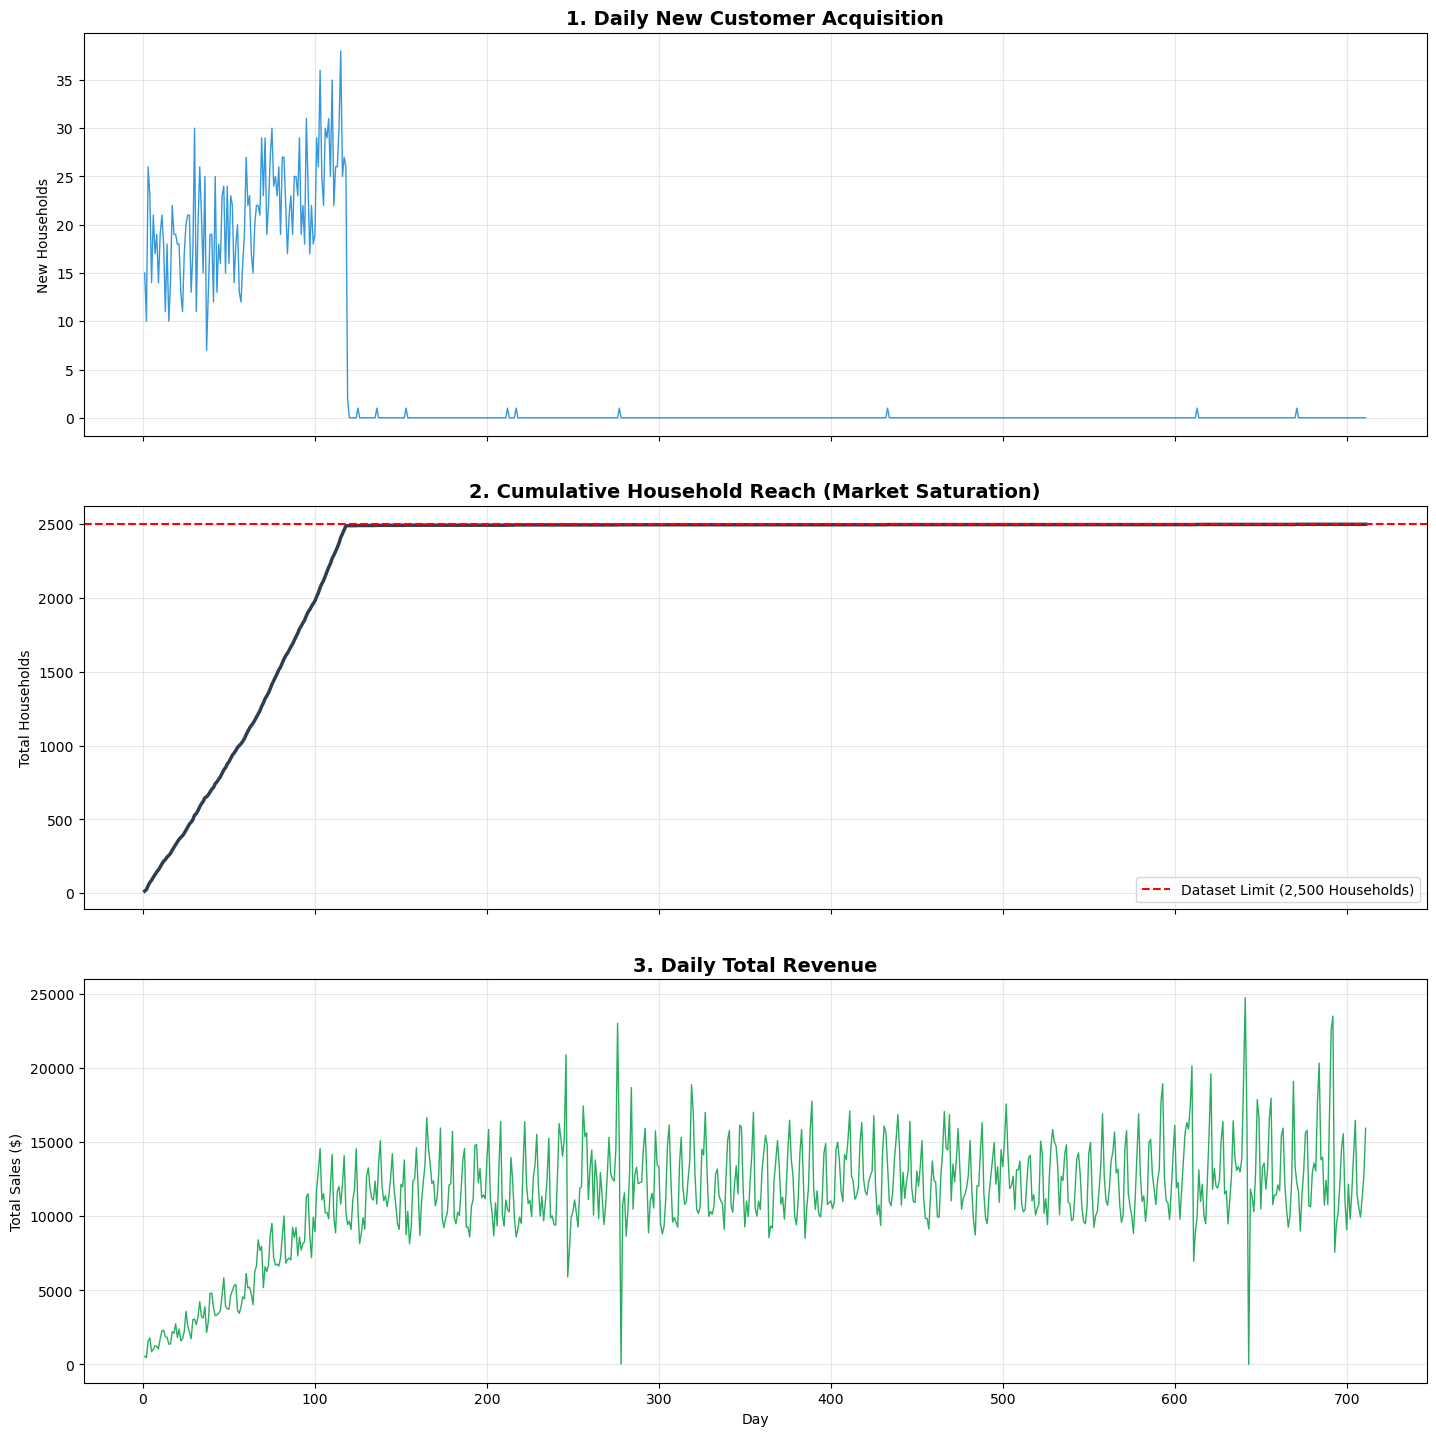

In [10]:
# ตั้งค่ากราฟ 3 กราฟ
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
# กราฟที่ 1: ลูกค้าใหม่รายวัน
ax1.plot(df_analysis['DAY'], df_analysis['new_customers_per_day'], color='#3498db', linewidth=1)
ax1.set_title('1. Daily New Customer Acquisition', fontsize=14, fontweight='bold')
ax1.set_ylabel('New Households')
ax1.grid(True, alpha=0.3)

# กราฟที่ 2: ยอดลูกค้าสะสม (Cumulative Household)
ax2.plot(df_analysis['DAY'], df_analysis['cumulative_household_count'], color='#2c3e50', linewidth=2.5)
ax2.axhline(y=2500, color='red', linestyle='--', label='Dataset Limit (2,500 Households)')
ax2.set_title('2. Cumulative Household Reach (Market Saturation)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Total Households')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# กราฟที่ 3: ยอดขายรายวัน
ax3.plot(df_analysis['DAY'], df_analysis['total_daily_sales'], color='#27ae60', linewidth=1)
ax3.set_title('3. Daily Total Revenue', fontsize=14, fontweight='bold')
ax3.set_ylabel('Total Sales ($)')
ax3.set_xlabel('Day')
ax3.grid(True, alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()

## ผลการวิเคราะห์

- จากกราฟที่ 1 จะเห็นได้ว่าแนวโน้มของลูกค้าใหม่มีจำนวนเพิ่มขึ้นจนถึงจุดๆหนึ่ง และเมื่อพิจารณาร่วมกับกราฟที่ 2 จะเห็นว่าจำนวนครัวเรือนสะสมที่ได้เข้ามาใช้บริการมีค่าเข้าใกล้ 2500 ซึ่งทั้ง 3 กราฟมีลักษณะเคลื่อนไหวในลักษณะคงที่ทีวันเดียวกัน
- สรุปได้ว่าสาเหตุที่รายได้ต่อวันมีลักษณะติดเพดานเนื่องจากขีดจำกัดของการรวบรวมข้อมูล ทำให้ขอบเขตของการวิเคราะห์จำกัดเพียง 2500 ครัวเรือน
- จากการวิเคราะห์ที่ผ่านมาจะเห็นว่ารายได้ต่อวันขึ้นอยู่กับจำนวนลูกค้า (Traffic) เป็นหลัก ทำให้เมื่อไม่มีลูกค้าใหม่ รายได้ต่อวันก็ไม่ปรับตัวสูงขึ้น

## 5. หาความสัมพันธ์ระหว่างส่วนลดที่กับยอดซื้อของลูกค้า

สมมติฐานคือหากลูกค้าได้รับส่วนลดมากขึ้นควรจะมียอดซื้อเพิ่มขึ้น เนื่องจาก
- ยอดส่วนลดรวมต่อ 1 ตะกร้าอาจจะมาจากการได้รับส่วนลดจากหลายสินค้า เมื่อซื้อสินค้าเยอะก็มีโอกาสได้รับส่วนลดเยอะ
- สินค้าที่มีส่วนลดอาจทำให้ลูกค้ามีความสนใจในการซื้อสินค้ามากยิ่งขึ้น

In [11]:
# Query ตะกร้า
query_basket = """
SELECT 
    "DAY",
    SUM("SALES_VALUE") / COUNT(DISTINCT "BASKET_ID") AS avg_revenue_per_basket,
    SUM(ABS("RETAIL_DISC") + ABS("COUPON_DISC") + ABS("COUPON_MATCH_DISC")) / COUNT(DISTINCT "BASKET_ID") AS avg_discount_per_basket
FROM transaction_data
GROUP BY "DAY"
ORDER BY "DAY" ASC;
"""

In [12]:
# 1. ดึงข้อมูล
df_basket = pd.read_sql(query_basket, conn)

# 2. คำนวณ Correlation (r) พฤติกรรมรายตะกร้า
r_basket = df_basket['avg_discount_per_basket'].corr(df_basket['avg_revenue_per_basket'])
print(f"basketalized Correlation (r) per Basket: {r_basket:.2f}")

C:\Users\User\AppData\Local\Temp\ipykernel_27576\2451567693.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_basket = pd.read_sql(query_basket, conn)


basketalized Correlation (r) per Basket: 0.75


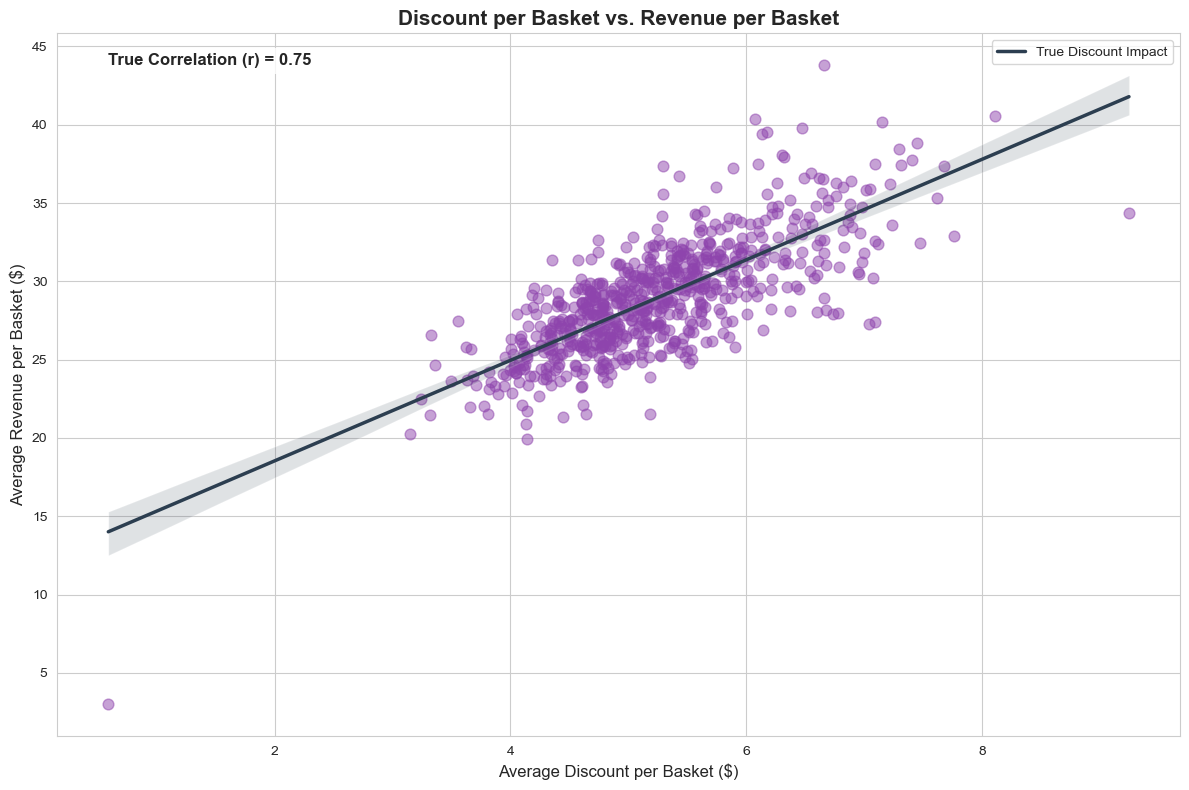

In [13]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# พล็อตความสัมพันธ์ระหว่าง "ส่วนลดที่ให้" กับ "ยอดที่ได้" ต่อหนึ่งบิล
sns.regplot(data=df_basket, x='avg_discount_per_basket', y='avg_revenue_per_basket', 
            scatter_kws={'alpha':0.5, 'color':'#8e44ad', 's':60}, 
            line_kws={'color':'#2c3e50', 'linewidth':2.5, 'label':'True Discount Impact'})

plt.title('Discount per Basket vs. Revenue per Basket', fontsize=15, fontweight='bold')
plt.xlabel('Average Discount per Basket ($)', fontsize=12)
plt.ylabel('Average Revenue per Basket ($)', fontsize=12)
plt.legend()

# ใส่ค่า correaltion
plt.text(df_basket['avg_discount_per_basket'].min(), df_basket['avg_revenue_per_basket'].max(), 
         f'True Correlation (r) = {r_basket:.2f}', fontsize=12, fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()

### ผลการวิเคราะห์:

พบว่าส่วนลดต่อตะกร้ามีและรายได้ที่ได้รับต่อตะกร้าความสัมพันธ์เชิงเส้นกันสูง (correlation = 0.75) ควรมีตรวจสอบเพิ่มเติมว่าความสัมพันธ์ที่ได้นี้ ส่วนลดทำให้ยอดการซื้อรวมสูงขึ้นจริงหรือไม่ หรือเป็นเพียงเพราะซื้อเยอะขึ้นทำให้ได้รับส่วนลดมากขึ้น

### 6. วิเคราะห์ยอดขายแต่ละสัปดาห์ตามดัชนีฤดูกาล (Seasonality)

จากการตรวจสอบรายได้รายวันที่พบว่ารายได้มีลักษณะผันผวนแบบมี Pattern ซึ่งอาจจะมีสาเหตุมาจากดัชนีฤดูกาล ทำการตรวจสอบรายได้รายวันในแต่ละสัปดาห์ มีสมมติฐานว่าแต่ละสัปดาห์วันเสาร์-อาทิตย์จะเป็นวันที่มีรายได้มากที่สุด

In [14]:
# Query สำหรับคำนวณ Seasonality Index
query_seasonality = """
WITH DailySales AS (
    SELECT "DAY", SUM("SALES_VALUE") as total_daily_revenue
    FROM transaction_data
    GROUP BY "DAY"
),
DayOfWeekStats AS (

    SELECT 
        (( ("DAY" - 1) % 7) + 1) AS day_of_week,
        AVG(total_daily_revenue) AS avg_rev_by_day
    FROM DailySales
    GROUP BY day_of_week
),
GlobalAverage AS (
    SELECT AVG(total_daily_revenue) AS global_avg_rev FROM DailySales
)
SELECT 
    d.day_of_week,
    d.avg_rev_by_day / g.global_avg_rev AS seasonality_index
FROM DayOfWeekStats d, GlobalAverage g
ORDER BY d.day_of_week;
"""

In [15]:
# เก็บผลลัพธ์ลงใน df_season
df_season = pd.read_sql(query_seasonality, conn)

print("Seasonality Index (1.0 = Average)")
print(df_season)

C:\Users\User\AppData\Local\Temp\ipykernel_27576\1126010624.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_season = pd.read_sql(query_seasonality, conn)


Seasonality Index (1.0 = Average)
   day_of_week  seasonality_index
0            1           0.870974
1            2           0.880471
2            3           0.976746
3            4           1.181693
4            5           1.228608
5            6           0.970711
6            7           0.891689


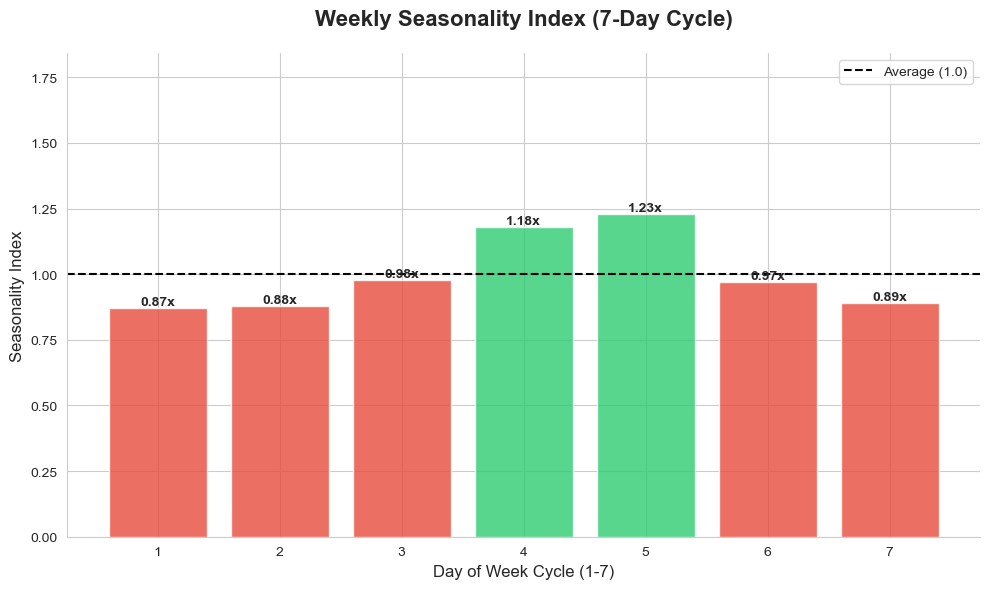

In [16]:
# 1. ตั้งค่าสไตล์
fig, ax = plt.subplots(figsize=(10, 6))

# พล็อตดัชนีฤดูกาล
# ถ้าเกิน 1 เป็นสีเขียว (ดีกว่าเฉลี่ย), ต่ำกว่า 1 เป็นสีแดง (แย่กว่าเฉลี่ย)
colors = ['#2ecc71' if x >= 1 else '#e74c3c' for x in df_season['seasonality_index']]
bars = ax.bar(df_season['day_of_week'], df_season['seasonality_index'], color=colors, alpha=0.8)

# ลากเส้นที่ Y=1
ax.axhline(1.0, color='black', linestyle='--', linewidth=1.5, label='Average (1.0)')

# ใส่เลขกำกับบนหัวแท่ง (กี่ % ของค่าเฉลี่ย)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}x', ha='center', va='bottom', fontweight='bold')

# Layout
ax.set_title('Weekly Seasonality Index (7-Day Cycle)', fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Day of Week Cycle (1-7)', fontsize=12)
ax.set_ylabel('Seasonality Index', fontsize=12)
ax.set_xticks(range(1, 8))
ax.set_ylim(0, df_season['seasonality_index'].max() * 1.5)

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### ผลการวิเคราะห์:

- จากการตรวจสอบดัชนีฤดูกาลพบว่าแต่ละวันได้รับอิทธิพลฤดูกาลแตกต่างกัน
- มี 2 วันที่มีดัชนีฤดูกาลของรายได้สูงกว่าปกติ คาดว่าเป็นวันเสาร์และวันอาทิตย์

## 7. นำดัชนีฤดูกาลที่ได้ไปตรวจสอบกับแพทเทิร์นของรายได้ต่อวันที่เกิดขึ้น

นำดัชนีฤดูกาลที่ได้ไปเปรียบเทียบกับการเคลื่อนไหวจริงของรายได้ต่อวัน

In [17]:
# Query สำหรับดึงยอดขายรายวันและตำแหน่งในรอบสัปดาห์
query_rev_weekly = """
SELECT 
    "DAY",
    (("DAY" - 1) % 7) + 1 AS day_of_cycle,
    (("DAY" - 1) / 7) + 1 AS week_number,
    SUM("SALES_VALUE") AS revenue
FROM transaction_data
GROUP BY "DAY"
ORDER BY "DAY" ASC;
"""

In [18]:
# ดึงข้อมูล
seasonal_rev_weekly = pd.read_sql(query_rev_weekly, conn)
seasonal_rev_weekly.head(10)

C:\Users\User\AppData\Local\Temp\ipykernel_27576\1699041184.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  seasonal_rev_weekly = pd.read_sql(query_rev_weekly, conn)


,DAY,day_of_cycle,week_number,revenue
0,1,1,1,549.31
1,2,2,1,458.91
2,3,3,1,1560.37
3,4,4,1,1785.64
4,5,5,1,856.93
5,6,6,1,1008.15
6,7,7,1,1271.29
7,8,1,2,1203.85
8,9,2,2,1050.95
9,10,3,2,1714.38


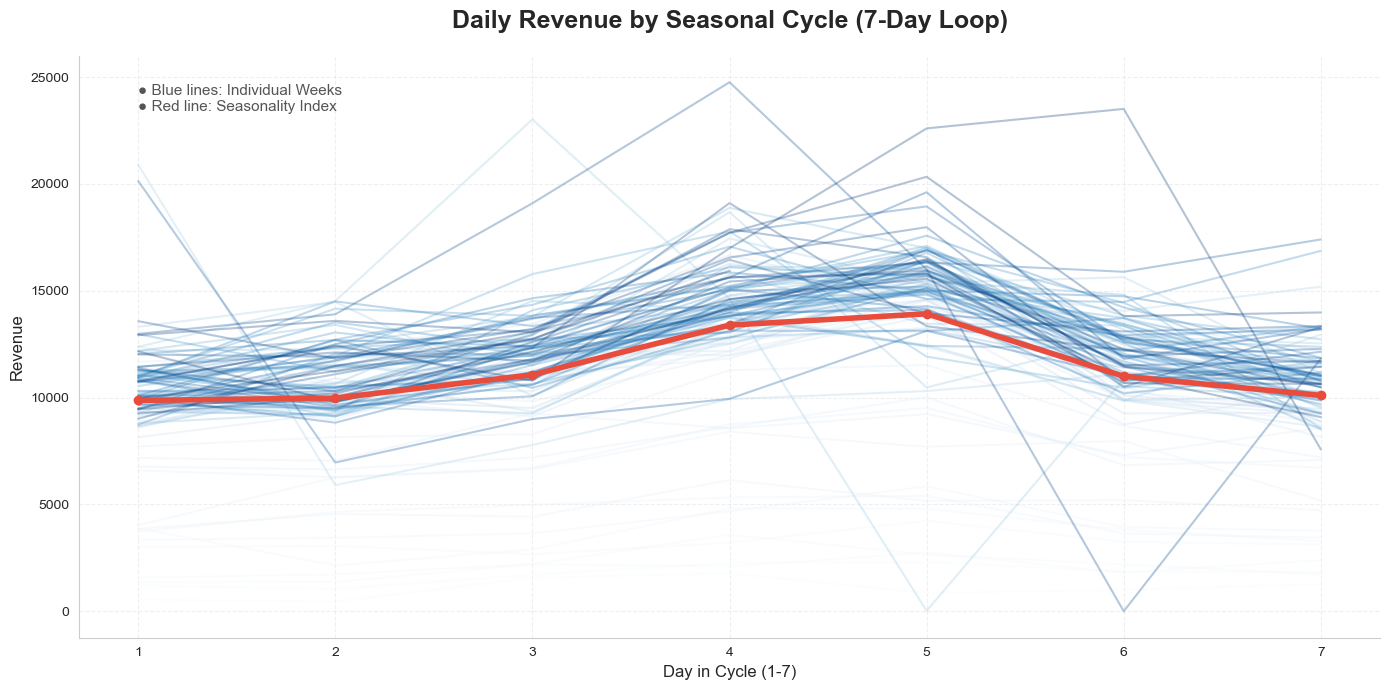

In [19]:
# ตั้งค่ากราฟ
fig, ax = plt.subplots(figsize=(14, 7))

# พล็อตเส้นยอดขายของแต่ละสัปดาห์ทับกัน
sns.lineplot(data=seasonal_rev_weekly, x='day_of_cycle', y='revenue', hue='week_number', 
             palette='Blues', alpha=0.3, legend=False, ax=ax)

# พล็อตเส้นค่าดัชนี
avg_pattern = seasonal_rev_weekly.groupby('day_of_cycle')['revenue'].mean().reset_index()
ax.plot(avg_pattern['day_of_cycle'], avg_pattern['revenue'], 
        color='#e74c3c', linewidth=4, marker='o', label='Average Seasonal Pattern')

# Layout
ax.set_title('Daily Revenue by Seasonal Cycle (7-Day Loop)', 
             fontsize=18, pad=20, fontweight='bold')
ax.set_xlabel('Day in Cycle (1-7)', fontsize=12)
ax.set_ylabel('Revenue', fontsize=12)
ax.set_xticks(range(1, 8))
ax.text(1, ax.get_ylim()[1]*0.95, '● Blue lines: Individual Weeks\n● Red line: Seasonality Index', 
        fontsize=11, color='#555555', verticalalignment='top')

ax.grid(True, linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### ผลการวิเคราะห์: 

- จากการวิเคราะห์พบว่ารายได้ในแต่ละสัปดาห์มี Pattern เกิดขึ้นจริงโดยวันที่ 4 และ 5 ที่คาดว่าเป็นวันเสาร์และวันอาทิตย์มักจะมีรายได้สูงกว่าวันอื่นๆ
- ในการวิเคราะห์อื่นจะกำหนดให้วันที่ 4 และ 5 นี้เป็นวันเสาร์และวันอาทิตย์ตามลำดับ

### วิเคราะห์เพิ่มเติม

จากการตรวจสอบ Seasonal Index ของยอดขายรายวันพบว่าในวันเสาร์อาทิตย์มียอดข้ายต่อวันสูงกว่าวันธรรมดา

ดำเนินการวิเคราะห์เพิ่มเติมโดยการตรวจสอบเพิ่มว่าในวันเสาร์อาทิตย์มีลูกค้ามากกว่าวันธรรมดาหรือไม่

In [20]:
# Query หาจำนวนตะกร้า (Traffic) รายวัน
query_traffic_seasonality = """
SELECT 
    "DAY",
    (( ("DAY" - 1) % 7) + 1) AS day_of_week,
    COUNT(DISTINCT "BASKET_ID") AS daily_basket_count,
    COUNT(DISTINCT "household_key") AS daily_customer_count
FROM transaction_data
GROUP BY "DAY"
ORDER BY "DAY" ASC;
"""

In [21]:
# ดึงข้อมูล
df_traffic = pd.read_sql(query_traffic_seasonality, conn)

# คำนวณหาค่าเฉลี่ยยอดผู้ใช้บริการ
avg_daily_traffic = df_traffic['daily_basket_count'].mean()

# หาค่าเฉลี่ยแยกตามวันในสัปดาห์ (Day 1-7)
seasonal_index_df = df_traffic.groupby('day_of_week')['daily_basket_count'].mean().reset_index()

# คำนวณดัชนีฤดูกาล (ค่าเฉลี่ยวันนั้น / ค่าเฉลี่ยรวม) * 100
seasonal_index_df['traffic_index'] = (seasonal_index_df['daily_basket_count'] / avg_daily_traffic) * 100

seasonal_index_df

C:\Users\User\AppData\Local\Temp\ipykernel_27576\1006285893.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_traffic = pd.read_sql(query_traffic_seasonality, conn)


,day_of_week,daily_basket_count,traffic_index
0,1,363.000000,93.348259
1,2,365.127451,93.895349
2,3,378.235294,97.266133
3,4,432.549020,111.233327
4,5,435.158416,111.904354
5,6,383.831683,98.705287
6,7,364.326733,93.689438


In [22]:
import pandas as pd

# 1. ดึงข้อมูล
df_traffic = pd.read_sql(query_traffic_seasonality, conn)

# 2. คำนวณหาค่าเฉลี่ยกลาง (Baseline) ของทั้งชุดข้อมูล
avg_daily_traffic = df_traffic['daily_basket_count'].mean()

# 3. หาค่าเฉลี่ยแยกตามวันในสัปดาห์ (Day 1-7)
seasonal_index_df = df_traffic.groupby('day_of_week')['daily_basket_count'].mean().reset_index()

# 4. คำนวณ Index: (ค่าเฉลี่ยวันนั้น / ค่าเฉลี่ยรวม) * 100
# $Index = \frac{\text{Mean Daily Traffic}}{\text{Overall Mean}} \times 100$
seasonal_index_df['traffic_index'] = (seasonal_index_df['daily_basket_count'] / avg_daily_traffic) * 100

print(f"Overall Average Traffic: {avg_daily_traffic:.2f} baskets/day")
print(seasonal_index_df)

C:\Users\User\AppData\Local\Temp\ipykernel_27576\1308515857.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_traffic = pd.read_sql(query_traffic_seasonality, conn)


Overall Average Traffic: 388.87 baskets/day
   day_of_week  daily_basket_count  traffic_index
0            1          363.000000      93.348259
1            2          365.127451      93.895349
2            3          378.235294      97.266133
3            4          432.549020     111.233327
4            5          435.158416     111.904354
5            6          383.831683      98.705287
6            7          364.326733      93.689438


C:\Users\User\AppData\Local\Temp\ipykernel_27576\245059245.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=seasonal_index_df, x='day_of_week', y='traffic_index', palette=colors)


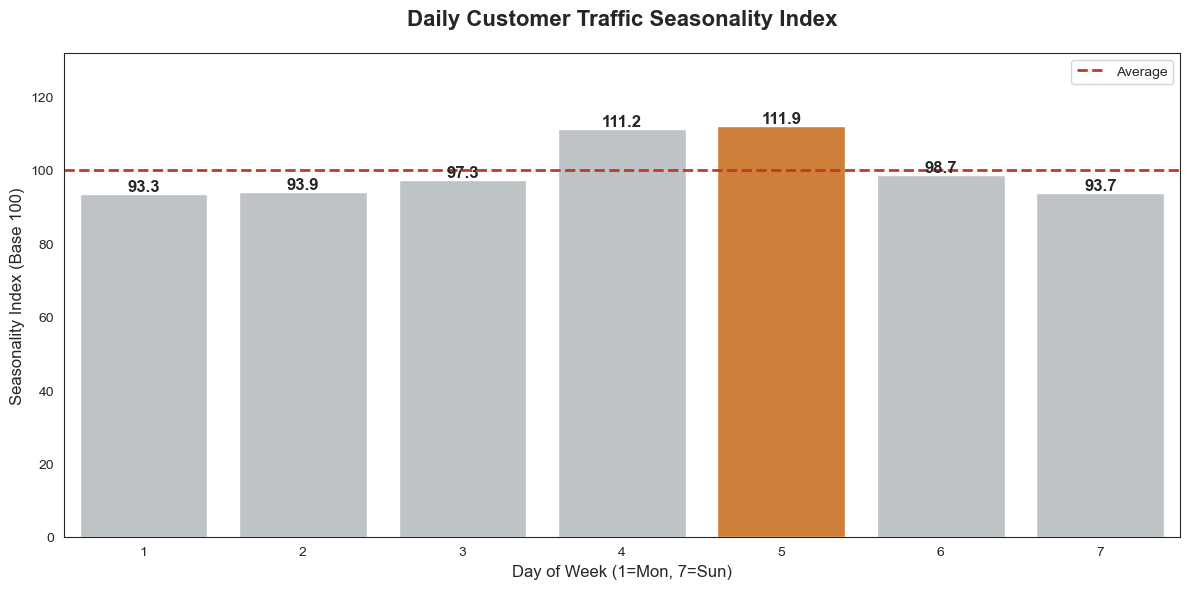

In [23]:
plt.figure(figsize=(12, 6))
sns.set_style("white")

# สร้างสี
colors = ['#e67e22' if x == seasonal_index_df['traffic_index'].max() else '#bdc3c7' 
          for x in seasonal_index_df['traffic_index']]

ax = sns.barplot(data=seasonal_index_df, x='day_of_week', y='traffic_index', palette=colors)

# ลากเส้น  Y=100
plt.axhline(100, color='#c0392b', linestyle='--', linewidth=2, label='Average')

# Layout
plt.title('Daily Customer Traffic Seasonality Index', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Day of Week (1=Mon, 7=Sun)', fontsize=12)
plt.ylabel('Seasonality Index (Base 100)', fontsize=12)
plt.ylim(0, seasonal_index_df['traffic_index'].max() + 20)

# ใส่ตัวเลขกำกับ
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()

### ผลการวิเคราะห์:

ผลการตรวจสอบดัชนีฤดูกาลของผู้ใช้บริการแต่ละวัน พบว่าวันเสาร์อาทิตย์นี้ก็มีผู้ใช้บริการมากกว่าวันธรรมดาเช่นกัน อย่างไรก็ตามค่าดัชนีที่ได้มีค่าต่ำกว่าดัชนีของยอดซื้อ ดังนั้น นอกจากจำนวนผู้ใช้บริการที่เพิ่มขึ้นแล้ว ยอดซื้อโดยเฉลี่ยก็อาจจะเพิ่มขึ้นด้วย

## 8. จากรายได้ที่เพิ่มขึ้นตรวจสอบว่ารายได้ที่เพิ่มขึ้นมีสาเหตุมาจากอะไรบ้าง

จากการวิเคราะห์ก่อนหน้าที่พบว่ายอดผู้ใช้บริการ (Traffic) ส่งผลต่อรายได้ต่อวันมากกว่ายอดใช้จ่ายเฉลี่ย 
- จึงตั้งสมมติฐานว่าวันเสาร์และวันอาทิตย์นี้มีจำนวนผู้ใชบริการเพิ่มขึ้น

In [24]:
query_seasonal_basket = """
WITH DailyBaskets AS (
    SELECT 
        "DAY",
        "BASKET_ID",
        SUM("SALES_VALUE") AS basket_value,
        (("DAY" - 1) % 7) + 1 AS seasonal_index
    FROM transaction_data
    GROUP BY "DAY", "BASKET_ID"
)
SELECT 
    seasonal_index,
    AVG(basket_value) AS avg_basket_size,
    COUNT(DISTINCT "BASKET_ID") AS total_traffic,
    SUM(basket_value) AS total_revenue
FROM DailyBaskets
GROUP BY seasonal_index
ORDER BY seasonal_index;
"""

In [25]:
df_seasonal_basket = pd.read_sql(query_seasonal_basket, conn)
df_seasonal_basket[['seasonal_index', 'avg_basket_size', 'total_traffic']]

C:\Users\User\AppData\Local\Temp\ipykernel_27576\3322679385.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_seasonal_basket = pd.read_sql(query_seasonal_basket, conn)


,seasonal_index,avg_basket_size,total_traffic
0,1,27.191117,37026
1,2,27.327460,37243
2,3,29.264976,38580
3,4,30.959805,44120
4,5,31.995936,43951
5,6,28.660113,38767
6,7,27.736467,36797


C:\Users\User\AppData\Local\Temp\ipykernel_27576\3190151383.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_seasonal_basket, x='seasonal_index', y='total_traffic',


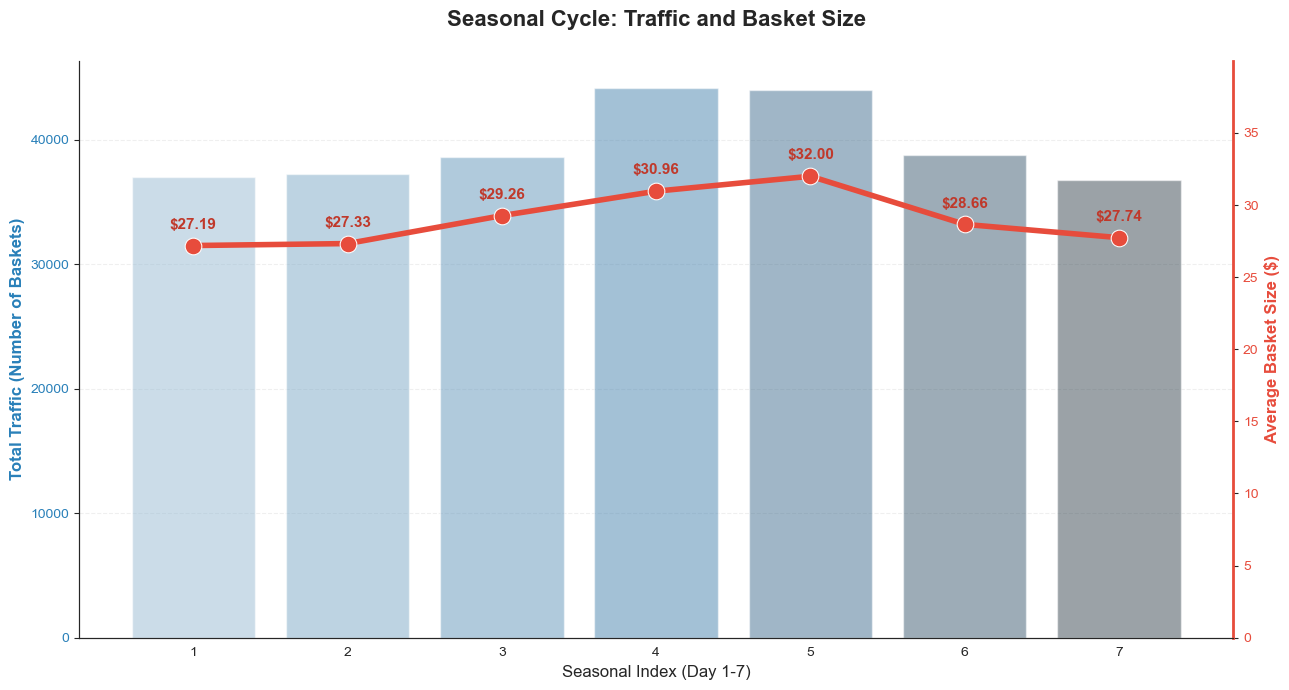

In [26]:
# ตั้งค่ากราฟ
fig, ax1 = plt.subplots(figsize=(13, 7))

# พล็อต Traffic
sns.barplot(data=df_seasonal_basket, x='seasonal_index', y='total_traffic', 
            palette='Blues_d', alpha=0.5, ax=ax1)
ax1.set_ylabel('Total Traffic (Number of Baskets)', fontsize=12, color='#2980b9', fontweight='bold')
ax1.set_xlabel('Seasonal Index (Day 1-7)', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#2980b9')

# สร้างแกน Y ที่สองสำหรับ Basket Size
ax2 = ax1.twinx()
sns.lineplot(data=df_seasonal_basket, x=df_seasonal_basket.index, y='avg_basket_size', 
             marker='o', color='#e74c3c', linewidth=4, markersize=12, ax=ax2)

# สร้างแกน Y ฝั่งขวาสีแดง
max_basket = df_seasonal_basket['avg_basket_size'].max()
ax2.set_ylim(0, max_basket * 1.25) 
ax2.set_ylabel('Average Basket Size ($)', fontsize=12, color='#e74c3c', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#e74c3c')
ax2.spines['right'].set_color('#e74c3c')
ax2.spines['right'].set_linewidth(2)

# ตัวเลขกำกับ
for i, val in enumerate(df_seasonal_basket['avg_basket_size']):
    ax2.text(i, val + (max_basket * 0.03), f'${val:.2f}', 
             color='#c0392b', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Layout
plt.title('Seasonal Cycle: Traffic and Basket Size', 
          fontsize=16, pad=25, fontweight='bold')
ax1.grid(True, axis='y', linestyle='--', alpha=0.3)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

### ผลการวิเคราะห์: จากกราฟข้างต้น พบว่าในวันเสาร์และวันอาทิตย์ (วันที่ 4 และ 5 ตามลำดับ) 

- วันเสาร์และวันอาทิตย์มีรายได้ต่อวันเพิ่มขึ้นมีสาเหตุมาจากทั้งยอดผู้ใช้บริการ (Traffic) ที่มีค่าสูงกว่าวันอื่นๆ
- นอกจากนี้ยังพบว่าครัวเรือนที่ใช้บริการในวันเสาร์และวันอาทิตย์มียอดใช้จ่ายเฉลี่ยสูงกว่าวันอื่นๆ สาเหตุอาจมาจากการที่แต่ละครัวเรือนมีการใช้จ่ายในวันหยุดสุดสัปดาห์ที่ผ่อนคลายมากกว่าอื่นๆ

### 9. การวิเคราะห์แผนที่ทำยอดขายเพิ่มได้มากที่สุดในช่วงวันหยุดสุดสัปดาห์ในวันปกติ

หาว่ายอดขายในวันสุดสัปดาห์ที่เพิ่มขึ้นมาจากแผนกใด เพื่อดำเนินการออกแบบกลยุทธเฉพาะ

In [27]:
# Query วิเคราะห์สินค้าในวันที่ 4-5 เรียงลำดับจากมากไปน้อย
query_peak_sorted = """
WITH DailyDeptSales AS (
    SELECT 
        p."DEPARTMENT",
        t."DAY",
        (( (t."DAY" - 1) % 7) + 1) AS day_of_week,
        SUM(t."SALES_VALUE") AS total_sales
    FROM transaction_data t
    JOIN product p ON t."PRODUCT_ID" = p."PRODUCT_ID"
    GROUP BY p."DEPARTMENT", t."DAY"
),
CategoryComparison AS (
    SELECT 
        "DEPARTMENT",
        AVG(CASE WHEN day_of_week IN (4, 5) THEN total_sales ELSE NULL END) AS avg_sales_peak_days,
        AVG(CASE WHEN day_of_week NOT IN (4, 5) THEN total_sales ELSE NULL END) AS avg_sales_normal_days
    FROM DailyDeptSales
    GROUP BY "DEPARTMENT"
)
SELECT 
    "DEPARTMENT",
    avg_sales_peak_days,
    avg_sales_normal_days,
    (avg_sales_peak_days / avg_sales_normal_days) AS sales_lift
FROM CategoryComparison
WHERE avg_sales_normal_days > 100 
ORDER BY avg_sales_peak_days DESC
LIMIT 10;
"""

In [28]:
# ดึงข้อมูลที่เรียงลำดับแล้ว
df_peak = pd.read_sql(query_peak_sorted, conn)
df_peak[['DEPARTMENT', 'avg_sales_peak_days']]

C:\Users\User\AppData\Local\Temp\ipykernel_27576\3453511553.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_peak = pd.read_sql(query_peak_sorted, conn)


,DEPARTMENT,avg_sales_peak_days
0,GROCERY,7125.917389
1,DRUG GM,1703.910296
2,MEAT,1004.426980
3,PRODUCE,957.497438
4,KIOSK-GAS,746.937222
5,MEAT-PCKGD,742.997772
6,DELI,458.822178
7,PASTRY,217.517228
8,MISC SALES TRAN,175.466256
9,NUTRITION,151.714129


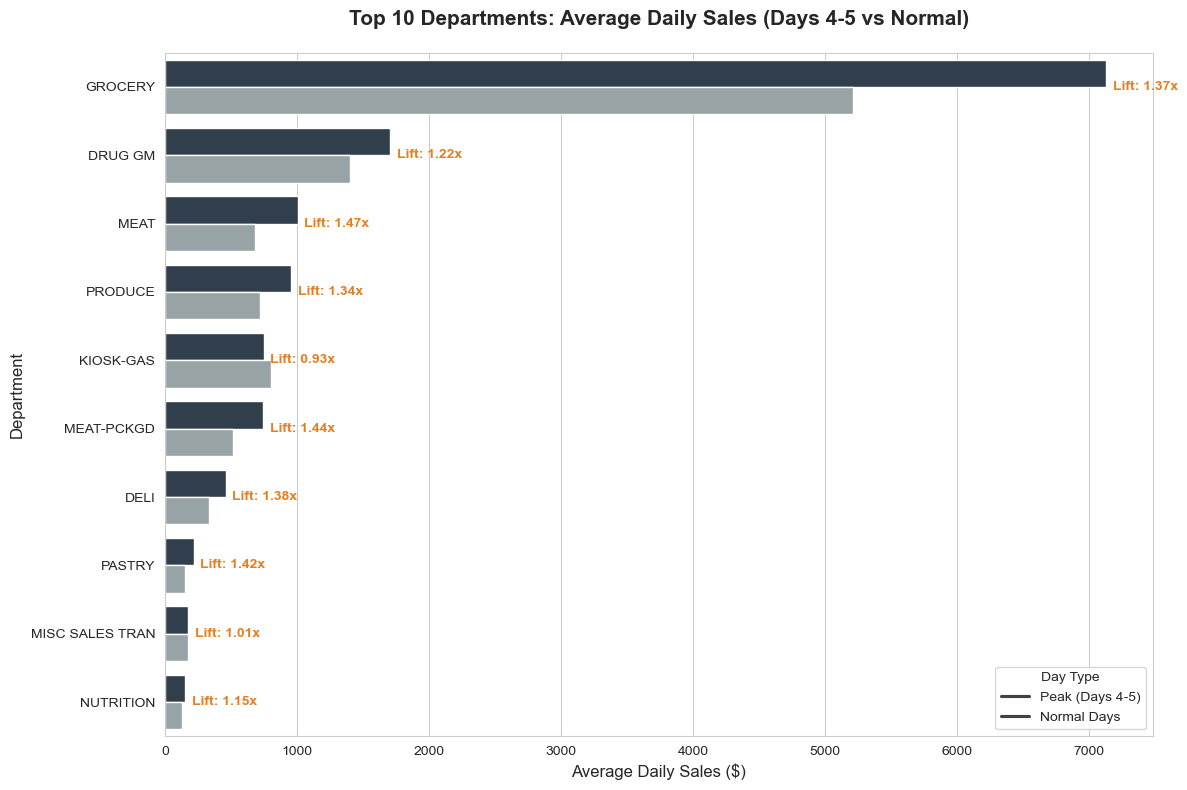

In [29]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# โครงสร้างข้อมูลสำหรับพล็อต
df_plot = df_peak.melt(id_vars='DEPARTMENT', 
                               value_vars=['avg_sales_peak_days', 'avg_sales_normal_days'],
                               var_name='Day_Type', value_name='Average_Sales')

# พล็อตตามลำดับ
ax = sns.barplot(data=df_plot, x='Average_Sales', y='DEPARTMENT', 
                 hue='Day_Type', palette=['#2c3e50', '#95a5a6'],
                 order=df_peak['DEPARTMENT'])

# Layout
plt.title('Top 10 Departments: Average Daily Sales (Days 4-5 vs Normal)', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Average Daily Sales ($)', fontsize=12)
plt.ylabel('Department', fontsize=12)
ax.legend(title='Day Type', labels=['Peak (Days 4-5)', 'Normal Days'])

# ใส่ตัวเลข Lift
for i, (avg_peak, lift) in enumerate(zip(df_peak['avg_sales_peak_days'], df_peak['sales_lift'])):
    ax.text(avg_peak + 50, i, f'Lift: {lift:.2f}x', va='center', fontsize=10, fontweight='bold', color='#e67e22')

plt.tight_layout()
plt.show()

### ผลการวิเคราะห์: 

เมื่อตรวจสอบแผนกที่มียอดขายต่อวันสูงสุดพบว่า 3 อันดับแผนกที่มียอดขายต่อวันสูงสุด ได้แก่ Grocery Drug GM และ Meat ต่างก็มียอดขายเพิ่มขึ้นในวันหยุดสุดสัปดาห์ โดย Grocery ที่ปกติก็ทำเงินได้มากอยู่แล้วก็ทำเงินมากขึ้นประมาณ 130%

## 10. ตรวจสอบว่าแต่ละวันภายในสัปดาห์ ประสิทธิภาพของส่วนลดมีความแตกต่างกันไหม

- จากอิทธิพลของวันหยุดสุดสัปดาห์ที่ชี้ให้เห็นว่า ยอดขายเพิ่มขึ้นอย่างมีนัยสำคัญ
- ตรวจสอบว่าส่วนลดจะกระตุ้นยอดซื้อขายหลักหักส่วนลดได้ดีที่สุดที่วันใดในแต่ละสัปดาห์

In [30]:
# Query คำนวณ Gross Revenue (ยอดก่อนหักส่วนลด) ต่อตะกร้า
query_impact = """
SELECT 
    "DAY",
    (( ("DAY" - 1) % 7) + 1) AS day_of_week,
    -- ยอดที่ลูกค้าจ่ายจริง (หลังหักส่วนลดแล้ว)
    SUM("SALES_VALUE") / COUNT(DISTINCT "BASKET_ID") AS avg_net_revenue_per_basket,
    -- รวมส่วนลดทุกประเภท (เป็นค่าบวก)
    SUM(ABS("RETAIL_DISC") + ABS("COUPON_DISC")) / COUNT(DISTINCT "BASKET_ID") AS avg_discount_given
FROM transaction_data
GROUP BY "DAY"
ORDER BY "DAY" ASC;
"""

In [31]:
# ดึงข้อมูล
df_impact = pd.read_sql(query_impact, conn)

# คำนวณ Correlation (r) ระหว่างส่วนลด กับ ยอดก่อนหักส่วนลด
impact = df_impact.groupby('day_of_week').apply(
    lambda x: x['avg_discount_given'].corr(x['avg_net_revenue_per_basket'])
).reset_index()

impact.columns = ['day_of_week', 'net_revenue_correlation_r']
impact

C:\Users\User\AppData\Local\Temp\ipykernel_27576\2164097256.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_impact = pd.read_sql(query_impact, conn)
C:\Users\User\AppData\Local\Temp\ipykernel_27576\2164097256.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  impact = df_impact.groupby('day_of_week').apply(


,day_of_week,net_revenue_correlation_r
0,1,0.665328
1,2,0.745044
2,3,0.716172
3,4,0.738702
4,5,0.716653
5,6,0.759775
6,7,0.612609


C:\Users\User\AppData\Local\Temp\ipykernel_27576\4105671859.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=impact, x='day_of_week', y='net_revenue_correlation_r', palette=colors)


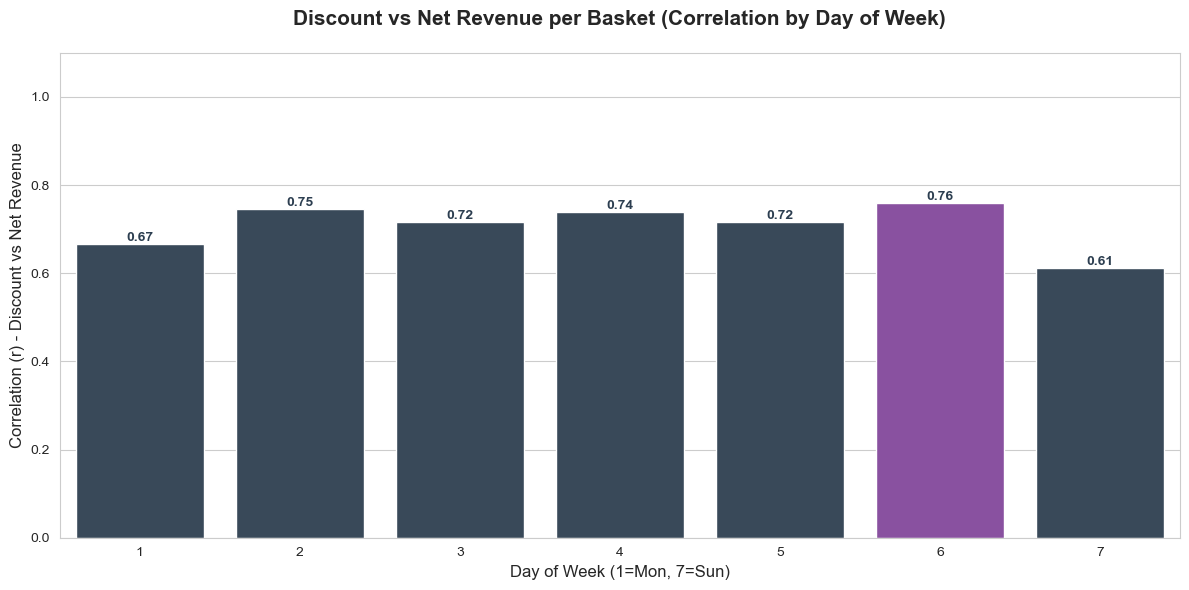

In [32]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# กำหนดสี
max_r = impact['net_revenue_correlation_r'].max()
colors = ['#8e44ad' if r == max_r else '#34495e' 
          for r in impact['net_revenue_correlation_r']]

# พล็อตค่า r ของ Net Revenue
ax = sns.barplot(data=impact, x='day_of_week', y='net_revenue_correlation_r', palette=colors)

# ชื่อกราฟและแกน
plt.title('Discount vs Net Revenue per Basket (Correlation by Day of Week)', 
          fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Day of Week (1=Mon, 7=Sun)', fontsize=12)
plt.ylabel('Correlation (r) - Discount vs Net Revenue', fontsize=12)

# ปรับขอบเขตแกน Y
plt.ylim(0, 1.1)

# เลขกำกับบนแท่ง
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontweight='bold', color='#2c3e50')

plt.tight_layout()
plt.show()

### ผลการวิเคราะห์:

พบว่าเมื่อคัดกรองข้อมูลแยกตามวันแล้วหา Correlation ระหว่างส่วนลดและยอดซื้อหลังหักส่วนลดในตามตะกร้า พบว่าส่วนลดและยอดซื้อหลังหักส่วนลดมีความสัมพันธ์กันสูงในระดับเดียวกันในทุกๆวัน

**สรุปว่า** ส่วนลดที่ลูกค้าได้รับในวันที่แตกต่างกัน ไม่มีผลในต่อรายได้หลักหักส่วนลดของบริษัท

## 11. ระหว่างส่วนลดที่ร้านค้าลดให้ ณ ชั้นวาง และส่วนลดที่ลูกค้าได้รับจากคูปอง ส่วนลดแบบใดขับเคลื่อนยอดซื้อหลังหักส่วนลดของลูกค้าได้ดีกว่า

In [33]:
# Query หาค่าเฉลี่ยยอดหลังหักส่วนลดและส่วนลดที่ให้ต่อหนึ่งตะกร้า
query_net_impact = """
SELECT 
    "DAY",
    (( ("DAY" - 1) % 7) + 1) AS day_of_week,
    -- ยอดที่จ่ายจริง (Net Revenue) หลังหักส่วนลดแล้ว
    SUM("SALES_VALUE") / COUNT(DISTINCT "BASKET_ID") AS avg_net_revenue,
    -- ส่วนลดหน้าร้าน (Retail Discount)
    SUM(ABS("RETAIL_DISC")) / COUNT(DISTINCT "BASKET_ID") AS avg_retail_disc,
    -- ส่วนลดจากคูปอง (Coupon & Match Discount)
    SUM(ABS("COUPON_DISC") + ABS("COUPON_MATCH_DISC")) / COUNT(DISTINCT "BASKET_ID") AS avg_coupon_disc
FROM transaction_data
GROUP BY "DAY"
ORDER BY "DAY";
"""

In [34]:
# ดึงข้อมูล
df_net = pd.read_sql(query_net_impact, conn)

# 2. คำนวณ Correlation (r) ระหว่างส่วนลด กับ ยอดจ่ายจริง (Net)
correlation_results = []
for dow in range(1, 8):
    subset = df_net[df_net['day_of_week'] == dow]
    
    # หาความสัมพันธ์ r
    r_retail = subset['avg_retail_disc'].corr(subset['avg_net_revenue'])
    r_coupon = subset['avg_coupon_disc'].corr(subset['avg_net_revenue'])
    
    correlation_results.append({
        'day_of_week': dow,
        'Retail_Impact_r': r_retail if not pd.isna(r_retail) else 0,
        'Coupon_Impact_r': r_coupon if not pd.isna(r_coupon) else 0
    })

df_corr_net = pd.DataFrame(correlation_results)
df_plot_net = df_corr_net.melt(id_vars='day_of_week', 
                                value_vars=['Retail_Impact_r', 'Coupon_Impact_r'],
                                var_name='Discount_Type', value_name='Correlation_R')

df_corr_net

C:\Users\User\AppData\Local\Temp\ipykernel_27576\3417025499.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_net = pd.read_sql(query_net_impact, conn)


,day_of_week,Retail_Impact_r,Coupon_Impact_r
0,1,0.672694,0.333687
1,2,0.732922,0.453678
2,3,0.713020,0.359289
3,4,0.740373,0.316298
4,5,0.699892,0.483574
5,6,0.758832,0.413807
6,7,0.605456,0.246672


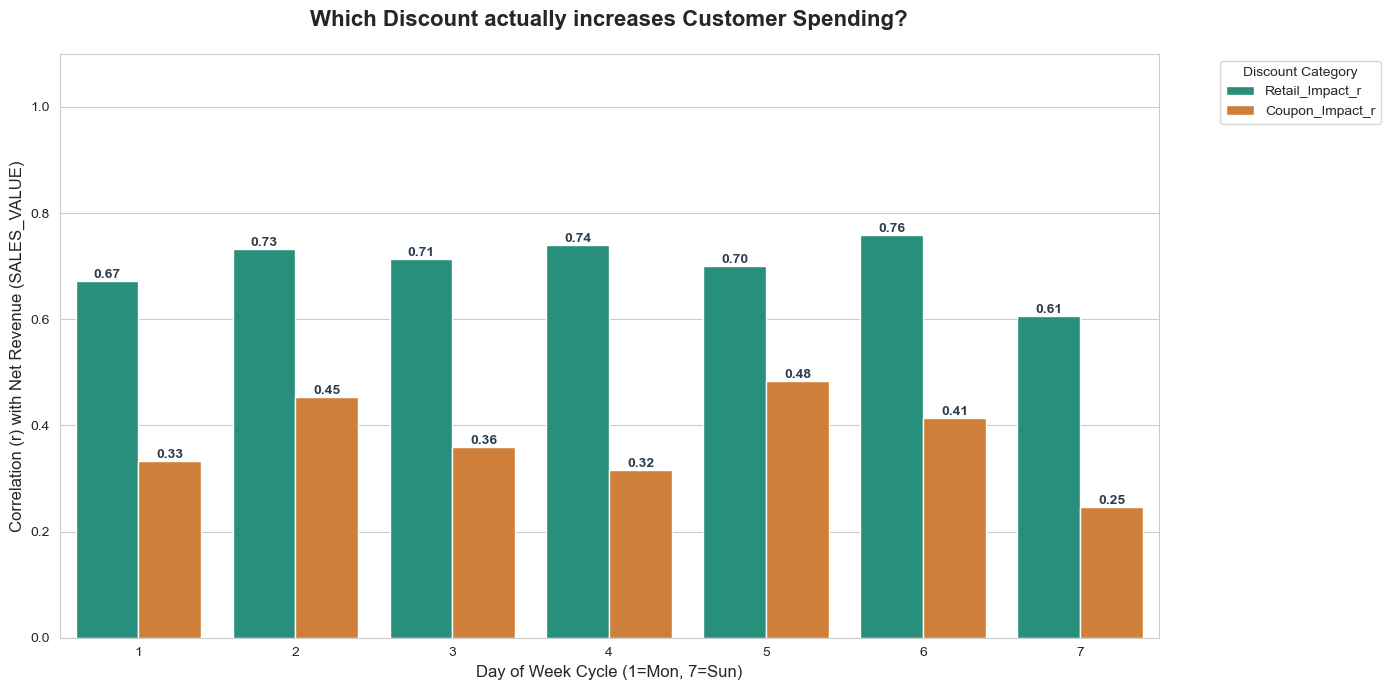

In [35]:
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# พล็อตเปรียบเทียบประสิทธิภาพ หิ้ง vs Coupon
ax = sns.barplot(data=df_plot_net, x='day_of_week', y='Correlation_R', 
                 hue='Discount_Type', palette=['#16a085', '#e67e22'])

plt.title('Which Discount actually increases Customer Spending?', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Day of Week Cycle (1=Mon, 7=Sun)', fontsize=12)
plt.ylabel('Correlation (r) with Net Revenue (SALES_VALUE)', fontsize=12)
plt.ylim(0, 1.1)
plt.legend(title='Discount Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# ใส่ค่า r กำกับ
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='#2c3e50')

plt.tight_layout()
plt.show()

### ผลการวิเคราะห์"

การที่ส่วนลดราคาป้าย (Retail Discount) มีความสัมพันธ์สูงกว่าคูปอง หมายความว่าลูกค้าส่วนใหญ่ตอบสนองต่อ **สิ่งที่เห็นตรงหน้า (ป้ายเหลืองบนหิ้ง)** มากกว่าส่วนลดประเภท **คูปอง**

ซึ่งผลลัพธ์ชี้ให้เห็นว่า การให้ส่วนลดเป็นรายสินค้าที่ชั้นวาง สามารถ Drive ยอดซื้อไม่รวมส่วนลดของลูกค้าได้ดีกว่า และผลที่ได้ของส่วนลดบนหิ้งก็มีความสม่ำเสมอในทุกๆวัน และอาจลดต้นทุนในการแจกคูปองได้อีกด้วย

# Product Analysis

การวิเคราะห์ผลิตภัณฑ์

## 11. วิเคราะห์ยอดขายของสินค้าแต่ละหมวดหมู่ย่อย

In [36]:
query_commodity = """
SELECT 
    p."COMMODITY_DESC", 
    SUM(t."SALES_VALUE") AS total_revenue,
    ROUND(
        SUM(t."SALES_VALUE") * 100.0 / SUM(SUM(t."SALES_VALUE")) OVER(), 
        4
    ) AS revenue_percentage
FROM transaction_data t
JOIN product p ON t."PRODUCT_ID" = p."PRODUCT_ID"
GROUP BY p."COMMODITY_DESC" 
ORDER BY total_revenue DESC
LIMIT 10;
"""

In [37]:
# ดึงข้อมูลมาเก็บใน df
df_commodity = pd.read_sql(query_commodity, conn)
df_commodity.head()

C:\Users\User\AppData\Local\Temp\ipykernel_27576\1705228623.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_commodity = pd.read_sql(query_commodity, conn)


,COMMODITY_DESC,total_revenue,revenue_percentage
0,COUPON/MISC ITEMS,639878.56,7.9414
1,SOFT DRINKS,327647.30,4.0664
2,BEEF,312103.22,3.8735
3,FLUID MILK PRODUCTS,205356.05,2.5486
4,CHEESE,189528.18,2.3522


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

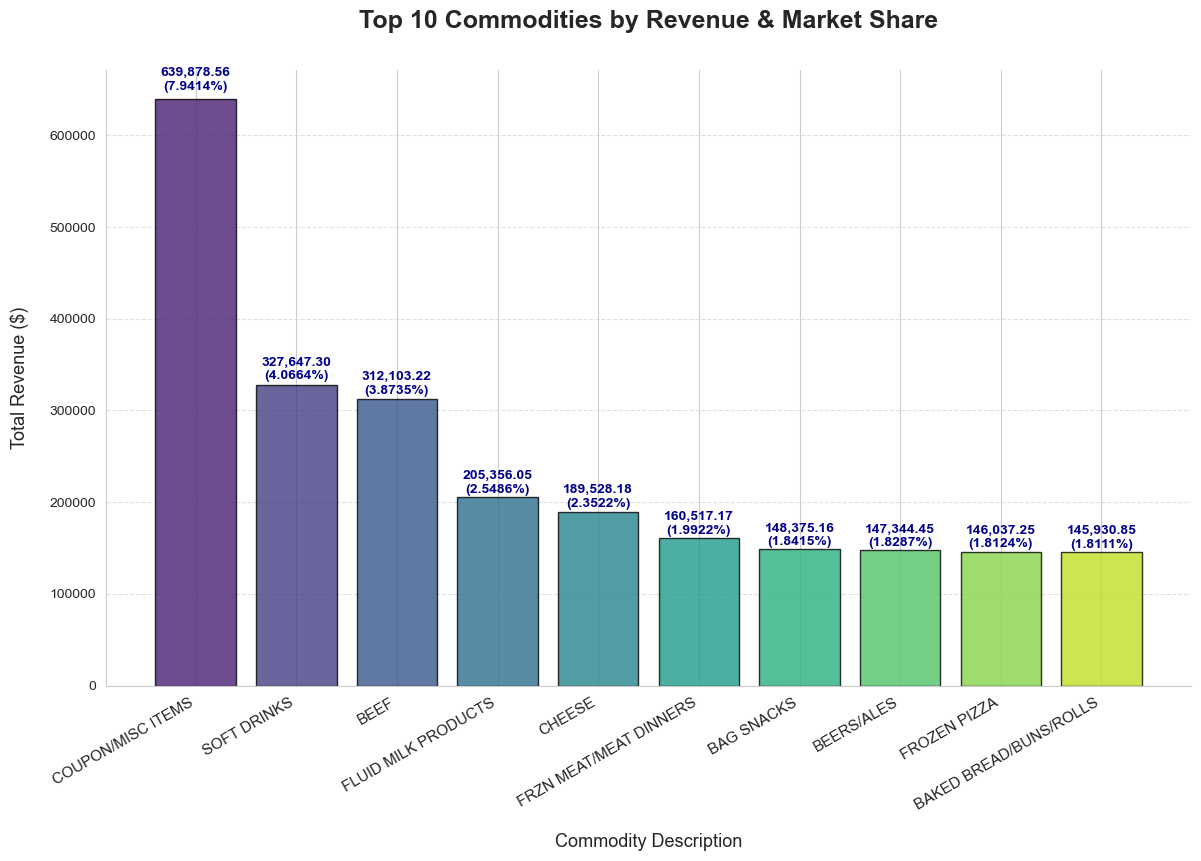

In [38]:
fig, ax = plt.subplots(figsize=(14, 8))

# สร้างกราฟแท่ง
colors = sns.color_palette("viridis", len(df_commodity))
bars = ax.bar(df_commodity['COMMODITY_DESC'], df_commodity['total_revenue'], color=colors, edgecolor='black', alpha=0.8)

# ตัวเลขกำกับ ยอดเงิน (เปอร์เซ็นต์%)
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = df_commodity['revenue_percentage'].iloc[i] 
    
    ax.text(bar.get_x() + bar.get_width()/2., height + (height * 0.01),
            f'{height:,.2f}\n({percentage}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='darkblue')

# Layout
ax.set_title('Top 10 Commodities by Revenue & Market Share', fontsize=18, pad=30, fontweight='bold')
ax.set_xlabel('Commodity Description', fontsize=13, labelpad=15)
ax.set_ylabel('Total Revenue ($)', fontsize=13, labelpad=15)
plt.xticks(rotation=30, ha='right', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout

### ผลการวิเคราะห์:

พบว่าสินค้าหมวดย่อยที่มียอดขายสูงที่สุดคือ COUPON/MISC ITEMS ซึ่งไม่ทราบแน่ชัดว่าหมายถึงหมวดหมู่ใดจึงขอแบ่งเป็น 2 กรณี
- กรณีแรก COUPON/MISC ITEMS คือสินค้าหมวดหนึ่ง จะกลายเป็นหมวด Hero ที่ควรมีการรักษายอดขายไว้เพราะหากลูกค้าเลิกซื้อหรือเลิกฮิตสินค้าหมวดนี้จะมีผลต่อรายได้ของบริษัทอย่างมาก
- กรณที่ COUPON/MISC ITEMS ไม่ใช่หมวดหมู่สินค้าจริง หมายความว่า รายได้มาจากสินค้าหลายๆหมวดซึ่งจะทำให้รายได้ที่เข้าสู่บริษัทมีความมั่นคง เนื่องจากมีรายได้จากหลายๆแหล่ง

## 12. ตรวจสอบความนิ่งของรายได้แต่ละทาง

ตรวจสอบว่ารายได้รวมเหล่านี้เป็นรายได้ที่มาจากการเกิดกระแส(ฉาบฉวย) หรือเป็นรายได้มีความมั่นคงและเกิดขึ้นมาโดยตลอด

In [39]:
# Query ข้อมูลยอดขาย Weekly
query_hero_weekly = """
WITH Weekly_Raw AS (
    SELECT 
        (( ("DAY" - 1) / 7) + 1) AS week_num,
        "PRODUCT_ID",
        "SALES_VALUE"
    FROM transaction_data
),
Top5_Hero AS (
    SELECT p."COMMODITY_DESC"
    FROM transaction_data t
    JOIN product p ON t."PRODUCT_ID" = p."PRODUCT_ID"
    GROUP BY p."COMMODITY_DESC"
    ORDER BY SUM(t."SALES_VALUE") DESC
    LIMIT 5
),
Weekly_Total AS (
    SELECT week_num, SUM("SALES_VALUE") as weekly_total_revenue
    FROM Weekly_Raw
    GROUP BY week_num
),
Weekly_Hero_Sales AS (
    SELECT 
        wr.week_num,
        p."COMMODITY_DESC",
        SUM(wr."SALES_VALUE") as hero_weekly_revenue
    FROM Weekly_Raw wr
    JOIN product p ON wr."PRODUCT_ID" = p."PRODUCT_ID"
    WHERE p."COMMODITY_DESC" IN (SELECT "COMMODITY_DESC" FROM Top5_Hero)
    GROUP BY wr.week_num, p."COMMODITY_DESC"
)
SELECT 
    h.week_num,
    h."COMMODITY_DESC",
    h.hero_weekly_revenue,
    d.weekly_total_revenue,
    (h.hero_weekly_revenue * 100.0 / d.weekly_total_revenue) as weekly_share_pct
FROM Weekly_Hero_Sales h
JOIN Weekly_Total d ON h.week_num = d.week_num
ORDER BY h.week_num ASC;
"""

In [40]:
# ดึงข้อมูล
df_hero_weekly = pd.read_sql(query_hero_weekly, conn)
df_hero_weekly.head(10)

C:\Users\User\AppData\Local\Temp\ipykernel_27576\4056654455.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_hero_weekly = pd.read_sql(query_hero_weekly, conn)


,week_num,COMMODITY_DESC,hero_weekly_revenue,weekly_total_revenue,weekly_share_pct
0,1,BEEF,267.56,7490.60,3.571944
1,1,CHEESE,164.64,7490.60,2.197955
2,1,COUPON/MISC ITEMS,3.99,7490.60,0.053267
3,1,FLUID MILK PRODUCTS,179.28,7490.60,2.393400
4,1,SOFT DRINKS,344.19,7490.60,4.594959
5,2,BEEF,476.30,12241.42,3.890888
6,2,CHEESE,313.52,12241.42,2.561141
7,2,COUPON/MISC ITEMS,35.26,12241.42,0.288038
8,2,FLUID MILK PRODUCTS,329.24,12241.42,2.689557
9,2,SOFT DRINKS,384.85,12241.42,3.143835


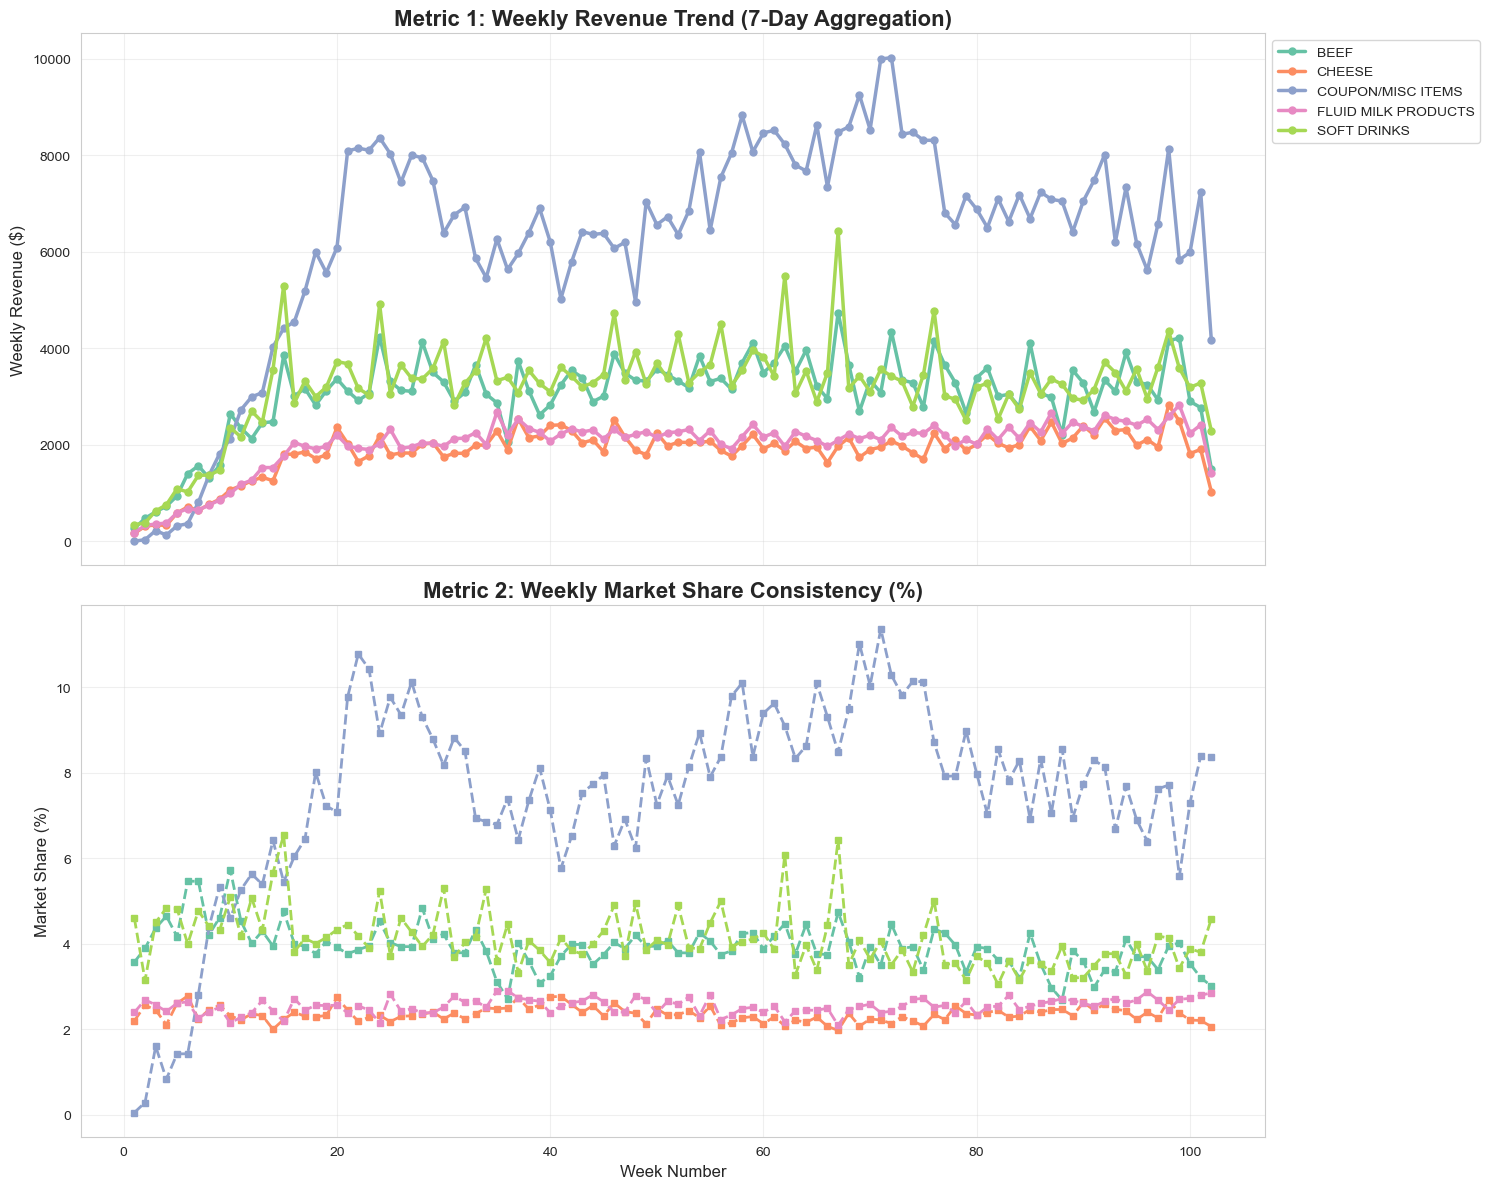

In [41]:
# พล็อตรายสัปดาห์
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

hero_list = df_hero_weekly['COMMODITY_DESC'].unique()
colors = sns.color_palette("Set2", len(hero_list))

# พล็อตทีละสินค้า
for i, commodity in enumerate(hero_list):
    subset = df_hero_weekly[df_hero_weekly['COMMODITY_DESC'] == commodity]
    
    # กราฟบน: ยอดขายรายสัปดาห์
    ax1.plot(subset['week_num'], subset['hero_weekly_revenue'], label=commodity, 
             color=colors[i], marker='o', markersize=5, linewidth=2.5)
    
    # กราฟล่าง: % ส่วนแบ่งรายสัปดาห์
    ax2.plot(subset['week_num'], subset['weekly_share_pct'], label=commodity, 
             color=colors[i], marker='s', markersize=5, linewidth=2, linestyle='--')

# Layout กราฟยอดขาย
ax1.set_title('Metric 1: Weekly Revenue Trend (7-Day Aggregation)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Weekly Revenue ($)', fontsize=12)
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.grid(True, alpha=0.3)

# Layout กราฟ % Share
ax2.set_title('Metric 2: Weekly Market Share Consistency (%)', fontsize=16, fontweight='bold')
ax2.set_ylabel('Market Share (%)', fontsize=12)
ax2.set_xlabel('Week Number', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### ผลการวิเคราะห์:

จากกราฟข้างต้นที่แสดงถึงรายได้ต่อสัปดาห์ และ Market Share เทียบกับเวลา พบว่ารายได้ที่เกิดขึ้นจากทุกหมวดสินค้าเป็นรายได้ที่เกิดขึ้นอย่างมั่นคง อาจเกิดการซื้อซ้ำของลูกค้า ไม่ได้เกิดจากการฉาบฉวยหรือเกิดกระแสต่อสินค้าบางกลุ่ม

## 13. ตรวจสอบว่าแผนกใดทำรายได้สูงสุด

เพื่อระบุแผนกที่เป็นรายได้หลักให้แก่บริษัท

In [42]:
query_department = """
SELECT 
    p."DEPARTMENT",
    SUM(t."SALES_VALUE") AS total_revenue,
    ROUND(
        SUM(t."SALES_VALUE") * 100.0 / SUM(SUM(t."SALES_VALUE")) OVER(), 
        4
    ) AS revenue_percentage
FROM transaction_data t
JOIN product p ON t."PRODUCT_ID" = p."PRODUCT_ID"
GROUP BY p."DEPARTMENT"
ORDER BY total_revenue DESC
LIMIT 10;
"""

In [43]:
# ดึงข้อมูล
df_department = pd.read_sql(query_department, conn)

df_department.head()

C:\Users\User\AppData\Local\Temp\ipykernel_27576\2166106996.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_department = pd.read_sql(query_department, conn)


,DEPARTMENT,total_revenue,revenue_percentage
0,GROCERY,4093814.14,50.8077
1,DRUG GM,1055358.03,13.0979
2,PRODUCE,557452.11,6.9185
3,MEAT,548786.81,6.8109
4,KIOSK-GAS,544222.28,6.7543


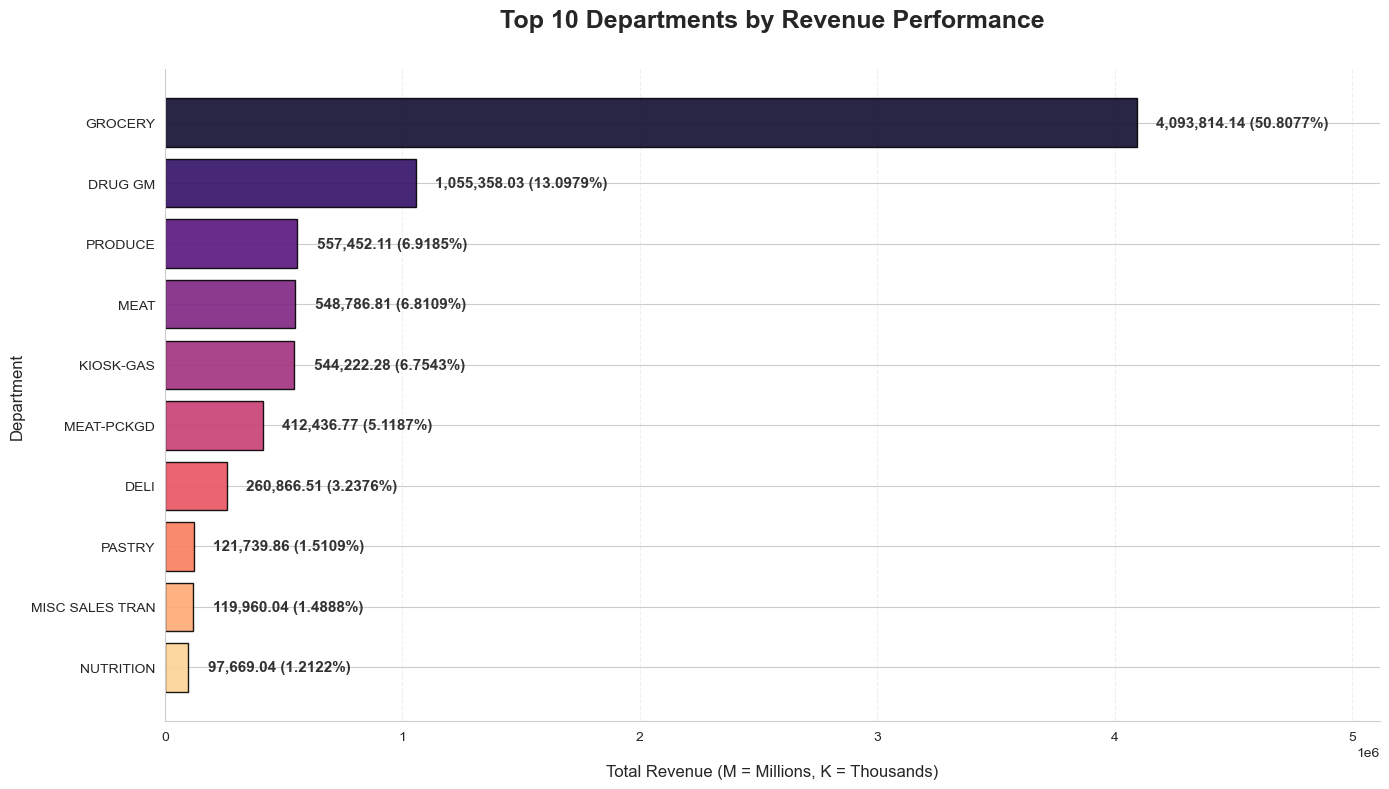

In [44]:
fig, ax = plt.subplots(figsize=(14, 8))

# สร้างสีไล่เฉด
colors = sns.color_palette("magma", len(df_department))

# พล็อตแนวนอน
bars = ax.barh(df_department['DEPARTMENT'], df_department['total_revenue'], 
               color=colors, edgecolor='black', alpha=0.9)

# ใส่เลขกำกับ
max_width = df_department['total_revenue'].max()
offset = max_width * 0.02

for i, bar in enumerate(bars):
    width = bar.get_width()
    percentage = df_department['revenue_percentage'].iloc[i]
    
    ax.text(width + offset, 
            bar.get_y() + bar.get_height()/2, 
            f'{width:,.2f} ({percentage}%)', 
            va='center', fontsize=11, fontweight='bold', color='#333333')

# Layout
ax.set_title('Top 10 Departments by Revenue Performance', fontsize=18, pad=30, fontweight='bold')
ax.set_xlabel('Total Revenue (M = Millions, K = Thousands)', fontsize=12, labelpad=15)
ax.set_ylabel('Department', fontsize=12)
ax.set_xlim(0, max_width + (max_width * 0.25))

ax.invert_yaxis()              
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False) 
ax.xaxis.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### ผลการวิเคราะห์:

พบว่าแผนกที่ทำรายได้สูงสุดให้กับบริษัทคือแผนก Grocery และมีลักษณะเป็น Hero Department เนื่องจากทำรายได้เยอะและมีความแตกต่างจากแผนกอื่นๆอย่างชัดเจน สาเหตุจากแผนของใช้ในครัวเรือนมีสินค้าที่ทุกบ้านต้องซื้อ และสินค้าเหล่านั้นเป็นสินค้าที่ต้องมีการซื้อซ้ำอยู่ตลอด

## 14. ตรวจสอบประสิทธิภาพของ Private Brand ที่ผลิตมาแข่งขันกับแบรนด์อื่นที่ไม่ใช่ของบริษัท

Private Brand มักเป็นสินค้าที่ห้างสรรพสินค้าผลิตขึ้นแล้วนำมาขายแข่งกับแบรนด์อื่นๆในราคาที่ต่ำกว่า 

การวิเคราะห์เพื่อประเมินประสิทธิภาพจัดทำการตรวจสอบ Value Share%(ส่วนแบ่งยอดขายทั้งหมด) และ Volume Share% (ส่วนแบ่งปริมาณที่ขายออก)

- **จะทำการตรวจสอบในหมวด Grocery เท่านั้น เนื่องจากเป็นหมวดที่มีการซื้อซ้ำสูงและเป็นหมวดที่ห้างสรรพสินค้ามักทำ Private Brand มากที่สุด**

In [45]:
# ดึงตัวเลขรวมของ National vs Private เฉพาะแผนก GROCERY
query_grocery_total = """
SELECT 
    p."BRAND",
    SUM(t."SALES_VALUE") as total_rev,
    SUM(t."QUANTITY") as total_qty
FROM transaction_data t
JOIN product p ON t."PRODUCT_ID" = p."PRODUCT_ID"
WHERE p."DEPARTMENT" = 'GROCERY'
  AND p."BRAND" IN ('National', 'Private')
GROUP BY 1
"""

In [46]:
df_grocery_total = pd.read_sql(query_grocery_total, conn)

C:\Users\User\AppData\Local\Temp\ipykernel_27576\2838705530.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_grocery_total = pd.read_sql(query_grocery_total, conn)


In [47]:
# เตรียมข้อมูลสำหรับ Donut
labels = df_grocery_total['BRAND'].tolist()
val_values = df_grocery_total['total_rev'].tolist()
vol_values = df_grocery_total['total_qty'].tolist()

# Visualization Donut Charts
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

# วงซ้าย: Value Share
fig.add_trace(go.Pie(
    labels=labels, 
    values=val_values, 
    name="Value Share",
    hole=0.5,
    marker=dict(colors=['#2c3e50', '#27ae60']),
    textinfo='percent+label',
), 1, 1)

# วงขวา: Volume Share
fig.add_trace(go.Pie(
    labels=labels, 
    values=vol_values, 
    name="Volume Share",
    hole=0.5,
    marker=dict(colors=['#34495e', '#2ecc71']),
    textinfo='percent+label',
), 1, 2)

# Layout
fig.update_layout(
    title_text="<b>GROCERY OVERALL PERFORMANCE</b><br>National Brand vs. Private Brand",
    annotations=[
        dict(text='Revenue', x=0.19, y=0.5, font_size=20, showarrow=False),
        dict(text='Volume', x=0.81, y=0.5, font_size=20, showarrow=False)
    ],
    height=500,
    showlegend=False
)

### ผลการวิเคราะห์: 

- พบว่าส่วนแบ่งของปริมาณสินค้า Private Brand ที่ขายออกของในหมวด Grocery คิดเป็น 36.4%
- อย่างไรก็ตามส่วนแบ่งยอดขาย (แผนภูมืโดนัทด้านซ้าย) กลับมีส่วนแบ่งน้อยกว่า National ฺbrand
- ชี้ให้เห็นว่าสินค้าเหล่านี้ลูกค้าตัดสินใจซื้อเนื่องจากมีราคาที่ต่ำกว่า National Brand หากมีการปรับราคาสูงขึ้น หรือลดราคาสินค้า National Brand มากเกินไป อาจทำให้รายได้จาก Private Brand เหล่านี้ ลดลงอย่างมีนัยสำคัญได้
- ถึงแม้ว่าสินค้า Private เหล่านี้มักจะมีราคาต่ำกว่าตลาดอยู่แล้ว ก็อาจจัดโปรโมชั่นลดราคาได้ หากมีการศึกษาชี้ชัดว่าสินค้าเหล่านี้มีความสัมพันธ์กับสินค้าทำเงินตัวอื่นๆ (Association Rule, eg.) หรือพิสูจน์ได้ว่าการลดราคาเหล่านั้นสามารถเรียกลูกค้าเข้าสู่ห้างสรรพสินค้าได้มากขึ้น ซึ่งอาจเป็นการเพิ่มยอดขายสินค้าอื่นๆในร้านค้าได้

In [48]:
conn.close()

# สรุปผลการวิเคราะห์

- การเพิ่มยอดขายรายวันมีส่วนเกี่ยวข้องชัดเจนกับการเพิ่มลูกค้าหน้าใหม่ ควรมีแคมเปญในการดึงลูกค้าใหม่อยู่เรื่อยๆ
- วันเสาร์และวันอาทิตย์เป็นวันที่มีลูกค้ามากที่สุด และลูกค้าอาจใช้จ่ายอย่างผ่อนคลายมากกว่าวันอื่นๆ (เนื่องจากวันเหล่านี้มียอดใช้จ่ายเฉลี่ยสูงกว่าวันอื่นๆ) สามารถพิจารณาจัดแคมเปญหรือวางแผนการตลาดเพิ่มเติมโดยเฉพาะสำหรับวันสุดสัปดาห์
- ส่วนลดบนหิ้งมีประสิทธิภาพกว่าการจัดโปรโมชั่นลดราคาด้วยคูปอง
- สินค้าในร้านค้ามาจากหลายหมวดไม่มีสินค้าใดเป็นสินค้า Hero (ข้อสรุปขึ้นกับการพิจารณาข้อ 11) และสินค้าเหล่านั้นเป็นสินค้าที่สร้างรายได้มั่นคงมาอย่างยาวนาน (ไม่ใช่รายได้ฉาบฉวย)
- แผนกที่ทำเงินได้มากที่สุดคือแผนก Grocery
- ผลิตภัณฑ์ Private Brand ในแผนก Grocery ที่วางขาย สามารถแย่งส่วนแบ่งจำนวนขายจากแบรนด์ภายนอกได้ **1 ใน 3** และสามารถแย่งส่วนแบ่งยอดขายได้ **1 ใน 4** ของสินค้าในแผนก Grocery ทั้งหมด